In [33]:
import torch
from transformers import WavLMModel, Wav2Vec2FeatureExtractor, AutoConfig
import torchaudio
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import numpy as np
import scipy
from scipy import signal
import math
import statsmodels.api as sm
import os, random, pathlib, re, shutil
os.chdir('/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/scripts')
fig_path = '/Users/jiamingxu/Desktop/Desktop - Jiaming’s MacBook Pro/Language_straightening/figures'


#### Load audio file 

In [ ]:
def load_mono_resampled(path, target_sr=16000):
    wav, sr = torchaudio.load(path)
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    if sr != target_sr:
        wav = torchaudio.transforms.Resample(sr, target_sr)(wav)
    return wav.squeeze(0)

waveform = load_mono_resampled("data/audios/wheretheressmoke.wav", target_sr=16000)
max_duration_sec = 30  # this is the length of the audio input 
waveform = waveform[: int(max_duration_sec * 16000)]

print("Waveform shape:", waveform.shape)


Waveform shape: torch.Size([480000])


#### Load the model and feature extractor

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

# Load the feature extractor
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-base-plus")
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large")

#  1) Load the pretrained WavLM model, force safetensors
# pre = WavLMModel.from_pretrained(
#     "microsoft/wavlm-base-plus",
#     output_hidden_states=True,
#     use_safetensors=True,      # for Intel mac (torch 2.2.x)
# ).to(device).eval()

# large 
pre = WavLMModel.from_pretrained(
    "microsoft/wavlm-large",
    output_hidden_states=True,
    use_safetensors=True,      # for Intel mac (torch 2.2.x)
).to(device).eval()

# 2) Randomly initialized WavLM (same architecture, no learned weights)
cfg = AutoConfig.from_pretrained("microsoft/wavlm-large")
rnd = WavLMModel(cfg).to(device).eval()  # randomly initialized



In [36]:
inputs = feature_extractor(waveform, sampling_rate=16000, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

def collect_wavlm_activations(model, inputs, hook_point="layer"):
    cnn, handles = [], []
    def hook(i):
        def fn(m, inp, out):
            x = out.detach().transpose(1,2).squeeze(0).cpu()  # [T, C]
            cnn.append((i, x))
        return fn
    for i, blk in enumerate(model.feature_extractor.conv_layers):
        target = blk if hook_point=="layer" else blk.conv
        handles.append(target.register_forward_hook(hook(i)))
    model.eval()
    with torch.no_grad():
        out = model(**inputs, output_hidden_states=True, return_dict=True)
    for h in handles: h.remove()
    cnn.sort(key=lambda t: t[0])
    tr = [h.squeeze(0).cpu() for h in out.hidden_states]  # [T_enc, D]
    return cnn, tr

cnn_pre, tr_pre = collect_wavlm_activations(pre, inputs, hook_point="layer")
cnn_rnd, tr_rnd = collect_wavlm_activations(rnd, inputs, hook_point="layer")

/Users/jiamingxu/miniconda3/envs/wavlm_env/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


In [37]:
def avg_curvature(X, max_duration_sec):
    V = np.diff(X, axis=0)                      # displacement vectors
    norms = np.linalg.norm(V, axis=1)           # step lengths

    v_prev, v_next = V[:-1], V[1:]
    denom = norms[:-1] * norms[1:] + 1e-12
    cos = (v_prev * v_next).sum(axis=1) / denom
    cos = np.clip(cos, -1.0, 1.0)               
    angles = np.degrees(np.arccos(cos)) 
    deg_per_step = angles.mean()

    # per second
    total_turn = angles.sum()
    deg_per_sec = total_turn / max_duration_sec

    # per unit distance
    total_distance = norms.sum()
    deg_per_unit_distance = total_turn / total_distance 
    return deg_per_step, deg_per_sec, deg_per_unit_distance


In [38]:
# change between cnn_pre and cnn_rnd to observe the effect of architecture 
cnn_per_step_curv = []
cnn_per_sec_curv = []
cnn_per_dist_curv = []
for cnn_layer in range(len(cnn_pre)):
    X = cnn_pre[cnn_layer][1].squeeze(0).numpy()  # shape: (nT, dim)
    print(X.shape)
    per_step_curv, per_sec_curv, per_dist_curv = avg_curvature(X, max_duration_sec)
    cnn_per_step_curv.append(per_step_curv)
    # cnn_per_sec_curv.append(per_sec_curv)
    cnn_per_dist_curv.append(per_dist_curv)
    # print(f"Per step curvature for CNN Layer {cnn_layer}: {per_step_curv:.2f} degrees")
    # print(f"Per second curvature for CNN Layer {cnn_layer}: {per_sec_curv:.2f} degrees")


(95999, 512)
(47999, 512)
(23999, 512)
(11999, 512)
(5999, 512)
(2999, 512)
(1499, 512)


In [39]:
# change between tr_pre and tr_rnd to observe the effect of architecture 
transformer_per_step_curv = []
transformer_per_sec_curv = []
transformer_per_dist_curv = []
for transformer_layer in range(len(tr_pre)):
    X = tr_pre[transformer_layer].squeeze(0).numpy()  # shape: (nT, dim)
    print(X.shape)
    per_step_curv, per_sec_curv, per_dist_curv = avg_curvature(X, max_duration_sec)
    transformer_per_step_curv.append(per_step_curv)
    transformer_per_sec_curv.append(per_sec_curv)
    transformer_per_dist_curv.append(per_dist_curv)
    # print(f"Per step curvature for Transformer Layer {transformer_layer}: {per_step_curv:.2f} degrees")
    # print(f"Per second curvature for Transformer Layer {transformer_layer}: {per_sec_curv:.2f} degrees")

(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)
(1499, 1024)


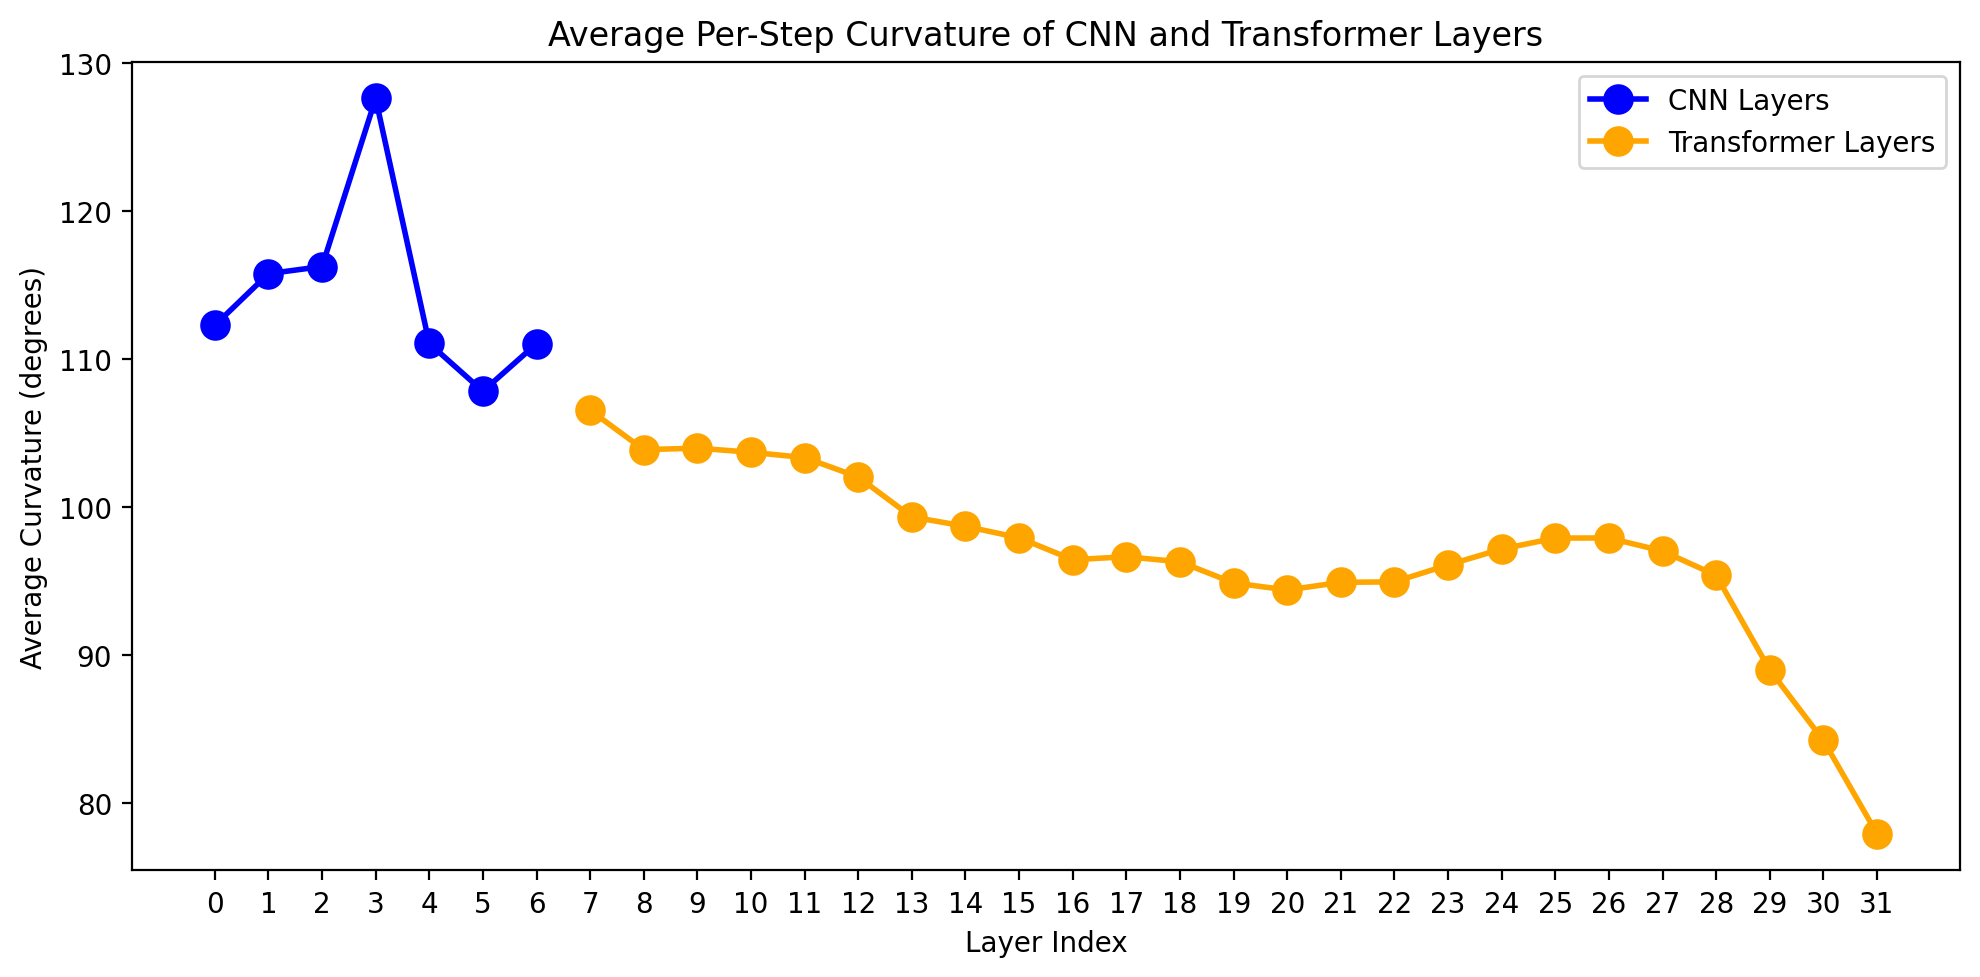

In [ ]:
# plot per step 
layers = np.arange(len(cnn_per_step_curv) + len(transformer_per_step_curv))
plt.figure(figsize=(10,5))

plt.plot(
    layers[:len(cnn_per_step_curv)], cnn_per_step_curv,
    marker='o', markersize=10, linewidth=2,
    label='CNN Layers', color='blue'
)

plt.plot(
    layers[len(cnn_per_step_curv):], transformer_per_step_curv,
    marker='o', markersize=10, linewidth=2,
    label='Transformer Layers', color='orange'
)

plt.title('Average Per-Step Curvature of CNN and Transformer Layers')
# plt.ylim(80, 130)
plt.xlabel('Layer Index')
plt.ylabel('Average Curvature (degrees)')
plt.xticks(layers)
plt.legend()
plt.tight_layout()

save_path = os.path.join(fig_path, "wavLM.pdf")
plt.savefig(save_path, format="pdf", bbox_inches="tight")



In [ ]:
### small figure for R01

# Build the shared layer index
layers = np.arange(len(cnn_per_step_curv) + len(transformer_per_step_curv))

# ---- tiny figure settings ----
dpi = 100                     # controls px when rasterized
fig_w = 75 / dpi
fig_h = 65 / dpi

fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)

# Plot with white marker outlines sized for a 65×65 px figure
ax.plot(
    layers[:len(cnn_per_step_curv)], cnn_per_step_curv,
    marker='o', markersize=2, linewidth=0.8,
    label='CNN Layers',
    color='#1f77b4',
    markerfacecolor='#1f77b4',
    markeredgecolor='white', markeredgewidth=0.3,
)

ax.plot(
    layers[len(cnn_per_step_curv):], transformer_per_step_curv,
    marker='o', markersize=2, linewidth=0.8,
    label='Transformer Layers',
    color='#ff7f0e',
    markerfacecolor='#ff7f0e',
    markeredgecolor='white', markeredgewidth=0.3,
)

# Remove all text/axes
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(''); ax.set_ylabel(''); ax.set_title('')
for s in ax.spines.values():
    s.set_visible(False)

# Tighten the drawing area to the data; fill the canvas
ax.margins(x=0.03, y=0.08)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

# Save as a tiny vector PDF with no padding
save_path = os.path.join(fig_path, "wavLM_small.pdf")
# plt.savefig(save_path, format='pdf', bbox_inches='tight', pad_inches=0)
plt.close(fig)


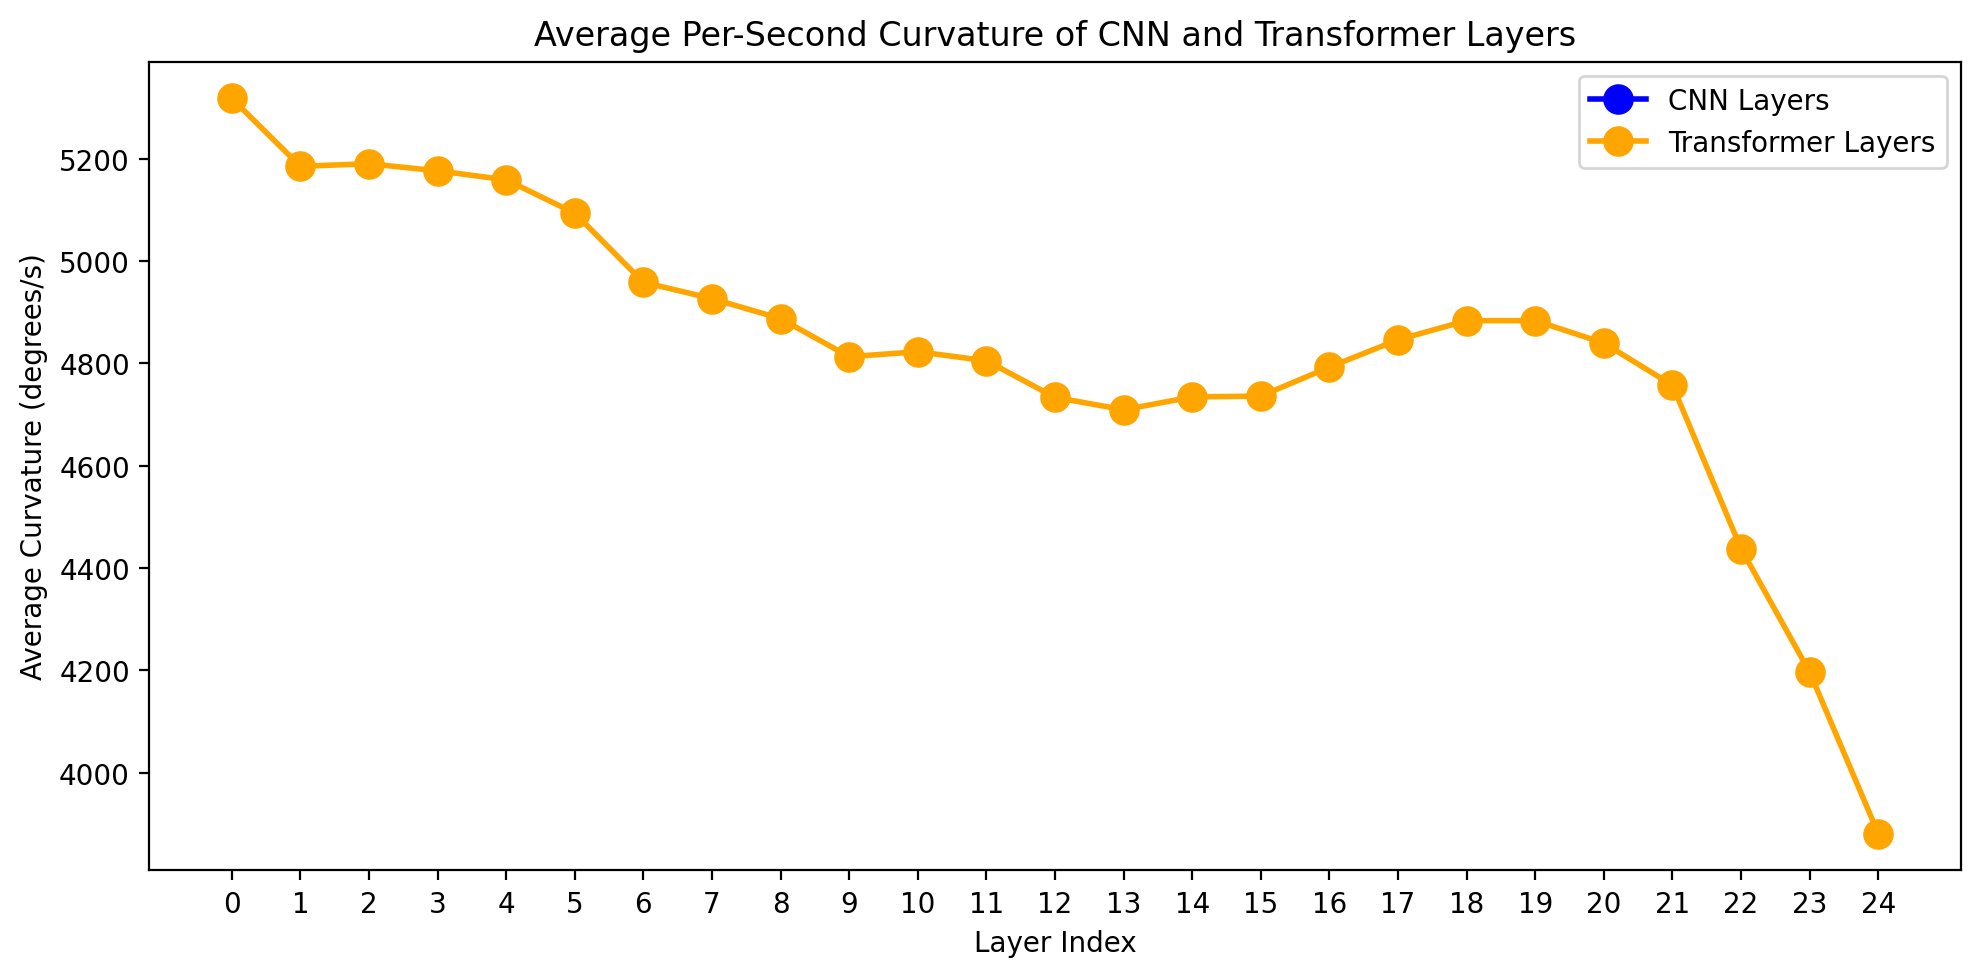

In [ ]:
# plot per second
layers = np.arange(len(cnn_per_sec_curv) + len(transformer_per_sec_curv))

plt.figure(figsize=(10, 5))

plt.plot(
    layers[:len(cnn_per_sec_curv)], cnn_per_sec_curv,
    marker='o', markersize=10, linewidth=2,
    label='CNN Layers', color='blue'
)

plt.plot(
    layers[len(cnn_per_sec_curv):], transformer_per_sec_curv,
    marker='o', markersize=10, linewidth=2,
    label='Transformer Layers', color='orange'
)

plt.title('Average Per-Second Curvature of CNN and Transformer Layers')
# plt.yscale("log")
plt.xlabel('Layer Index')
plt.ylabel('Average Curvature (degrees/s)')
plt.xticks(layers)
plt.legend()
plt.tight_layout()
save_path = os.path.join(fig_path, "wavLM.pdf")
# plt.savefig(save_path, format='pdf', bbox_inches='tight')

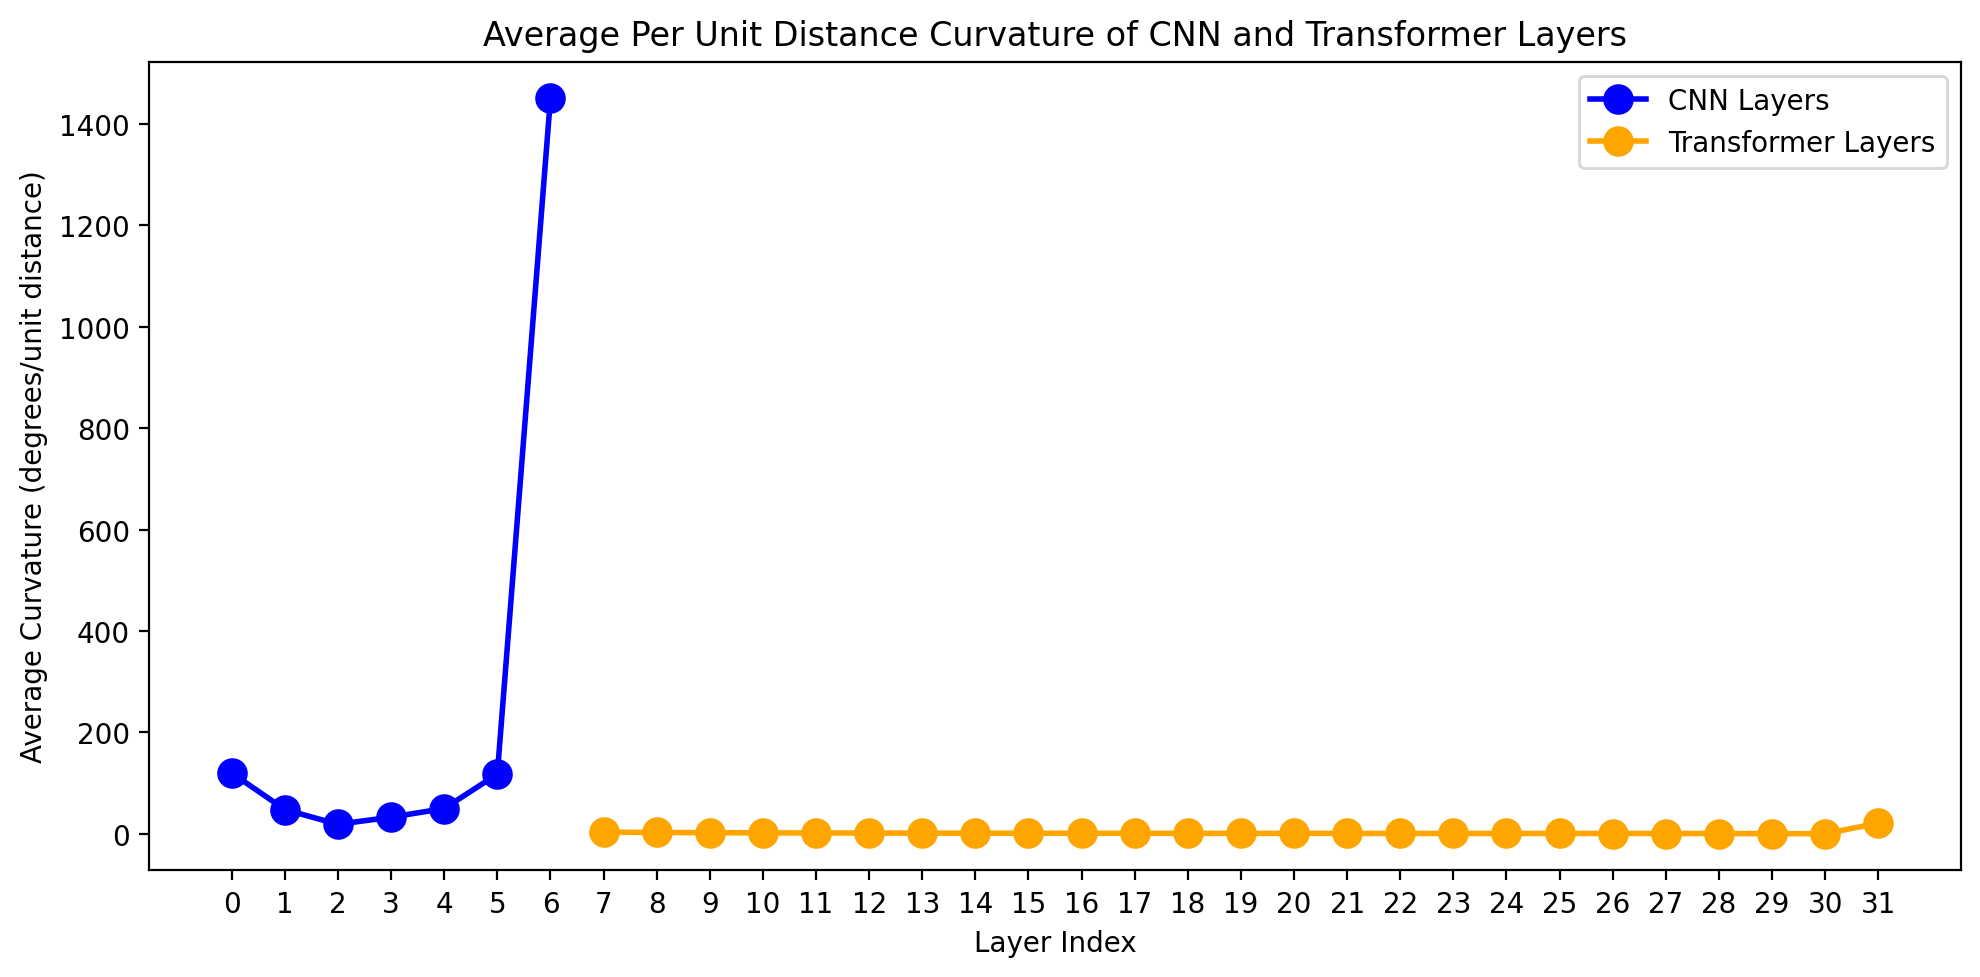

In [12]:
# plot per unit distance
layers = np.arange(len(cnn_per_dist_curv) + len(transformer_per_dist_curv))

plt.figure(figsize=(10, 5))

plt.plot(
    layers[:len(cnn_per_dist_curv)], cnn_per_dist_curv,
    marker='o', markersize=10, linewidth=2,
    label='CNN Layers', color='blue'
)

plt.plot(
    layers[len(cnn_per_dist_curv):], transformer_per_dist_curv,
    marker='o', markersize=10, linewidth=2,
    label='Transformer Layers', color='orange'
)

plt.title('Average Per Unit Distance Curvature of CNN and Transformer Layers')
# plt.yscale("log")
plt.xlabel('Layer Index')
plt.ylabel('Average Curvature (degrees/unit distance)')
plt.xticks(layers)
plt.legend()
plt.tight_layout()

#### Compute the per-step curvature across layers on the sub-sampled audio clips, see if stimulus properties have effects on curvature

In [61]:
# get various subsamples of the stimulus
target_sr = 16000
clip_sec = 10
n_random_clips = 100
seed = 123
out_dir = "data/audios/10s_clips"
os.makedirs(out_dir, exist_ok=True)
random.seed(seed)

# ---- clear and recreate folder ----
if os.path.exists(out_dir):
    shutil.rmtree(out_dir)       
os.makedirs(out_dir, exist_ok=True)

def subsample_audio(path, out_dir, clip_sec, k=n_random_clips, sr=target_sr):
    wav = load_mono_resampled(path, sr)
    total_len = wav.numel()
    win_len = int(clip_sec * sr)

    max_start = total_len - win_len
    starts = [random.randint(0, max_start) for _ in range(k)]
    saved_paths = []
    timestamps = {}

    base = pathlib.Path(path).stem
    for i, s in enumerate(starts):
        clip = wav[s : s + win_len]
        out_name = f"{base}_{i:03d}.wav"
        out_path = os.path.join(out_dir, out_name)
        torchaudio.save(out_path, clip.unsqueeze(0), sr)
        saved_paths.append(out_path)
        # print(f"Saved {out_path}")
        # print(f"\n✅ Saved {len(saved_paths)} random 10 s clips from {path}")

        start_sec = s / sr
        timestamps[out_name] = start_sec
    return saved_paths, timestamps 

snippet_paths, timestamps = subsample_audio("data/audios/wheretheressmoke.wav", out_dir, clip_sec, k=n_random_clips, sr=target_sr)

In [62]:
# save timestamps of the randomly sampled 10s clips for later analysis
import json
json_path = os.path.join(out_dir, "wheretheressmoke_timestamps.json")
with open(json_path, "w") as f:
    json.dump(timestamps, f, indent=2)

Compute curvatures in pre-trained model

/Users/jiamingxu/miniconda3/envs/wavlm_env/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[1/100] processed clip 000
[2/100] processed clip 001
[3/100] processed clip 002
[4/100] processed clip 003
[5/100] processed clip 004
[6/100] processed clip 005
[7/100] processed clip 006
[8/100] processed clip 007
[9/100] processed clip 008
[10/100] processed clip 009
[11/100] processed clip 010
[12/100] processed clip 011
[13/100] processed clip 012
[14/100] processed clip 013
[15/100] processed clip 014
[16/100] processed clip 015
[17/100] processed clip 016
[18/100] processed clip 017
[19/100] processed clip 018
[20/100] processed clip 019
[21/100] processed clip 020
[22/100] processed clip 021
[23/100] processed clip 022
[24/100] processed clip 023
[25/100] processed clip 024
[26/100] processed clip 025
[27/100] processed clip 026
[28/100] processed clip 027
[29/100] processed clip 028
[30/100] processed clip 029
[31/100] processed clip 030
[32/100] processed clip 031
[33/100] processed clip 032
[34/100] processed clip 033
[35/100] processed clip 034
[36/100] processed clip 035
[

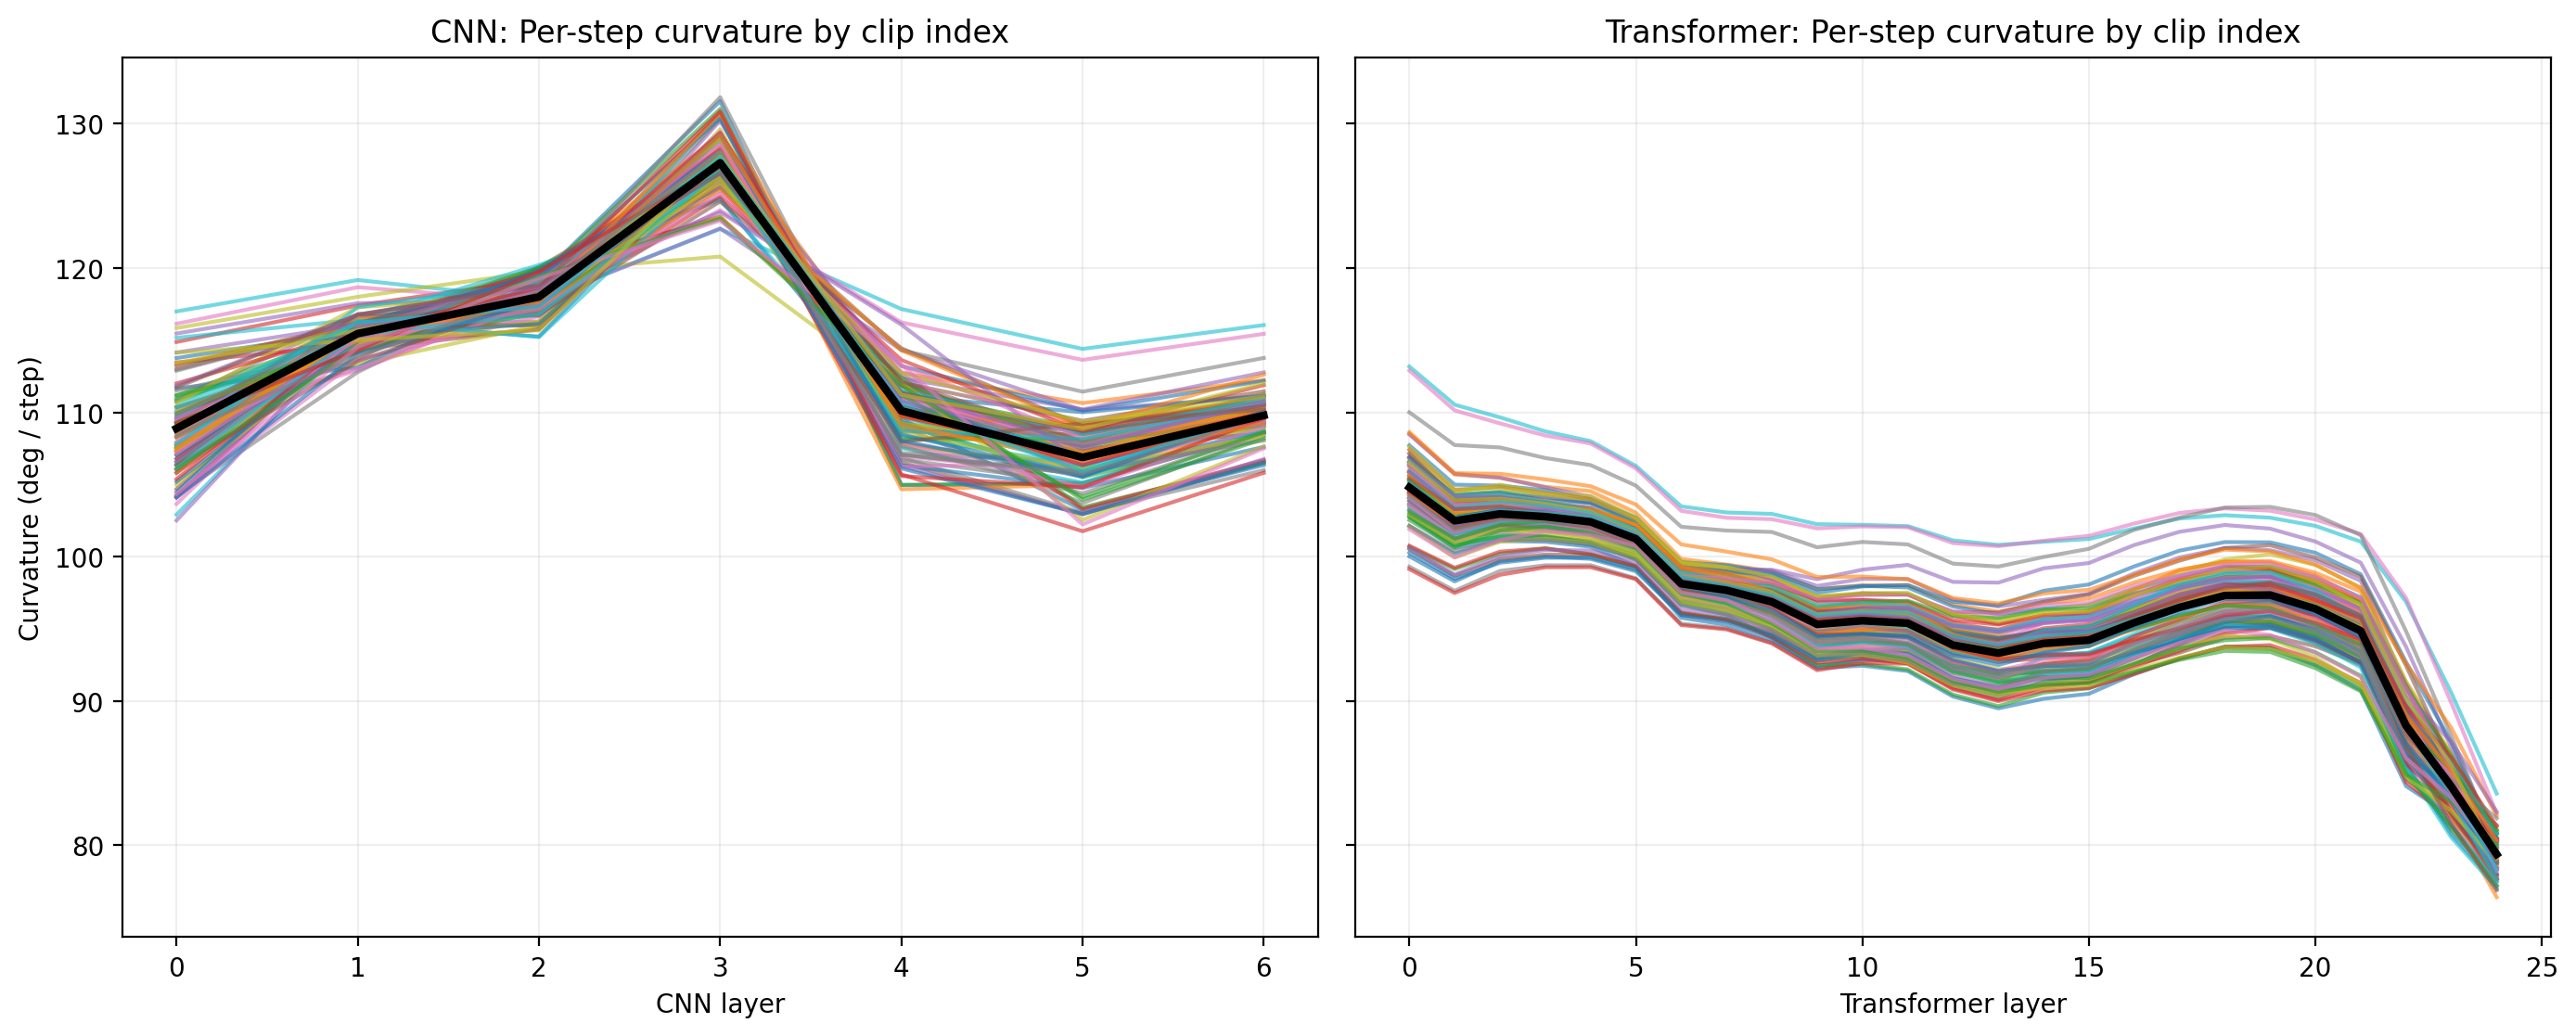

In [126]:
HOP_S = 0.02 # this parameter is only needed when computing per second curvature.
SAVE_PDF = "wavlm_curvature_snippets_byindex.pdf"

all_cnn_per_step, all_tr_per_step = [], []
clip_labels = []  # numeric clip indices for legend

# ---- loop over all snippets ----
for si, wav_path in enumerate(snippet_paths):
    wav = load_mono_resampled(wav_path, 16000)
    inputs = feature_extractor(wav.numpy(), sampling_rate=16000, return_tensors="pt")
    inputs = {k: v.to(next(pre.parameters()).device) for k, v in inputs.items()}

    cnn_pre, tr_pre = collect_wavlm_activations(pre, inputs, hook_point="layer")

    cnn_per_step_curv = []
    for li in range(len(cnn_pre)):
        X = cnn_pre[li][1].squeeze(0).numpy()
        max_duration_sec = (X.shape[0] - 1) * HOP_S
        per_step, _, _ = avg_curvature(X, max_duration_sec)
        cnn_per_step_curv.append(per_step)

    tr_per_step_curv = []
    for li in range(len(tr_pre)):
        X = tr_pre[li].squeeze(0).numpy()
        max_duration_sec = (X.shape[0] - 1) * HOP_S
        per_step, _, _ = avg_curvature(X, max_duration_sec)
        tr_per_step_curv.append(per_step)

    all_cnn_per_step.append(np.asarray(cnn_per_step_curv))
    all_tr_per_step.append(np.asarray(tr_per_step_curv))

    # extract just the numeric index from the filename (e.g., "000" from "wheretheressmoke_000.wav")
    filename = os.path.basename(wav_path)
    match = re.search(r'_(\d+)\.wav$', filename)
    clip_labels.append(match.group(1) if match else str(si))

    print(f"[{si+1}/{len(snippet_paths)}] processed clip {clip_labels[-1]}")

# ---- stack arrays ----
cnn_mat = np.vstack(all_cnn_per_step)
tr_mat  = np.vstack(all_tr_per_step)

cnn_L, tr_L = cnn_mat.shape[1], tr_mat.shape[1]
x_cnn = np.arange(cnn_L)
x_tr  = np.arange(tr_L)

# ---- plotting ----
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- CNN subplot ---
for i in range(cnn_mat.shape[0]):
    axs[0].plot(x_cnn, cnn_mat[i], linewidth=1.5, alpha=0.6, label=clip_labels[i])
axs[0].plot(x_cnn, np.nanmean(cnn_mat, axis=0), linewidth=3, color="black", label="Mean curvature")
axs[0].set_title("CNN: Per-step curvature by clip index")
axs[0].set_xlabel("CNN layer")
axs[0].set_ylabel("Curvature (deg / step)")
axs[0].grid(alpha=0.2)

# --- Transformer subplot ---
for i in range(tr_mat.shape[0]):
    axs[1].plot(x_tr, tr_mat[i], linewidth=1.5, alpha=0.6, label=clip_labels[i])
axs[1].plot(x_tr, np.nanmean(tr_mat, axis=0), linewidth=3, color="black", label="Mean curvature")
axs[1].set_title("Transformer: Per-step curvature by clip index")
axs[1].set_xlabel("Transformer layer")
axs[1].grid(alpha=0.2)

# # --- Combined legend outside both panels ---
# handles, labels = axs[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc="upper center", ncol=8, fontsize=7,
#            bbox_to_anchor=(0.5, 1.05), frameon=False, title="Clip Index")

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(SAVE_PDF, format="pdf", bbox_inches="tight")
plt.show()



Compute curvatures in untrained model

/Users/jiamingxu/miniconda3/envs/wavlm_env/lib/python3.12/site-packages/torch/nn/functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


[1/100] processed clip 000
[2/100] processed clip 001
[3/100] processed clip 002
[4/100] processed clip 003
[5/100] processed clip 004
[6/100] processed clip 005
[7/100] processed clip 006
[8/100] processed clip 007
[9/100] processed clip 008
[10/100] processed clip 009
[11/100] processed clip 010
[12/100] processed clip 011
[13/100] processed clip 012
[14/100] processed clip 013
[15/100] processed clip 014
[16/100] processed clip 015
[17/100] processed clip 016
[18/100] processed clip 017
[19/100] processed clip 018
[20/100] processed clip 019
[21/100] processed clip 020
[22/100] processed clip 021
[23/100] processed clip 022
[24/100] processed clip 023
[25/100] processed clip 024
[26/100] processed clip 025
[27/100] processed clip 026
[28/100] processed clip 027
[29/100] processed clip 028
[30/100] processed clip 029
[31/100] processed clip 030
[32/100] processed clip 031
[33/100] processed clip 032
[34/100] processed clip 033
[35/100] processed clip 034
[36/100] processed clip 035
[

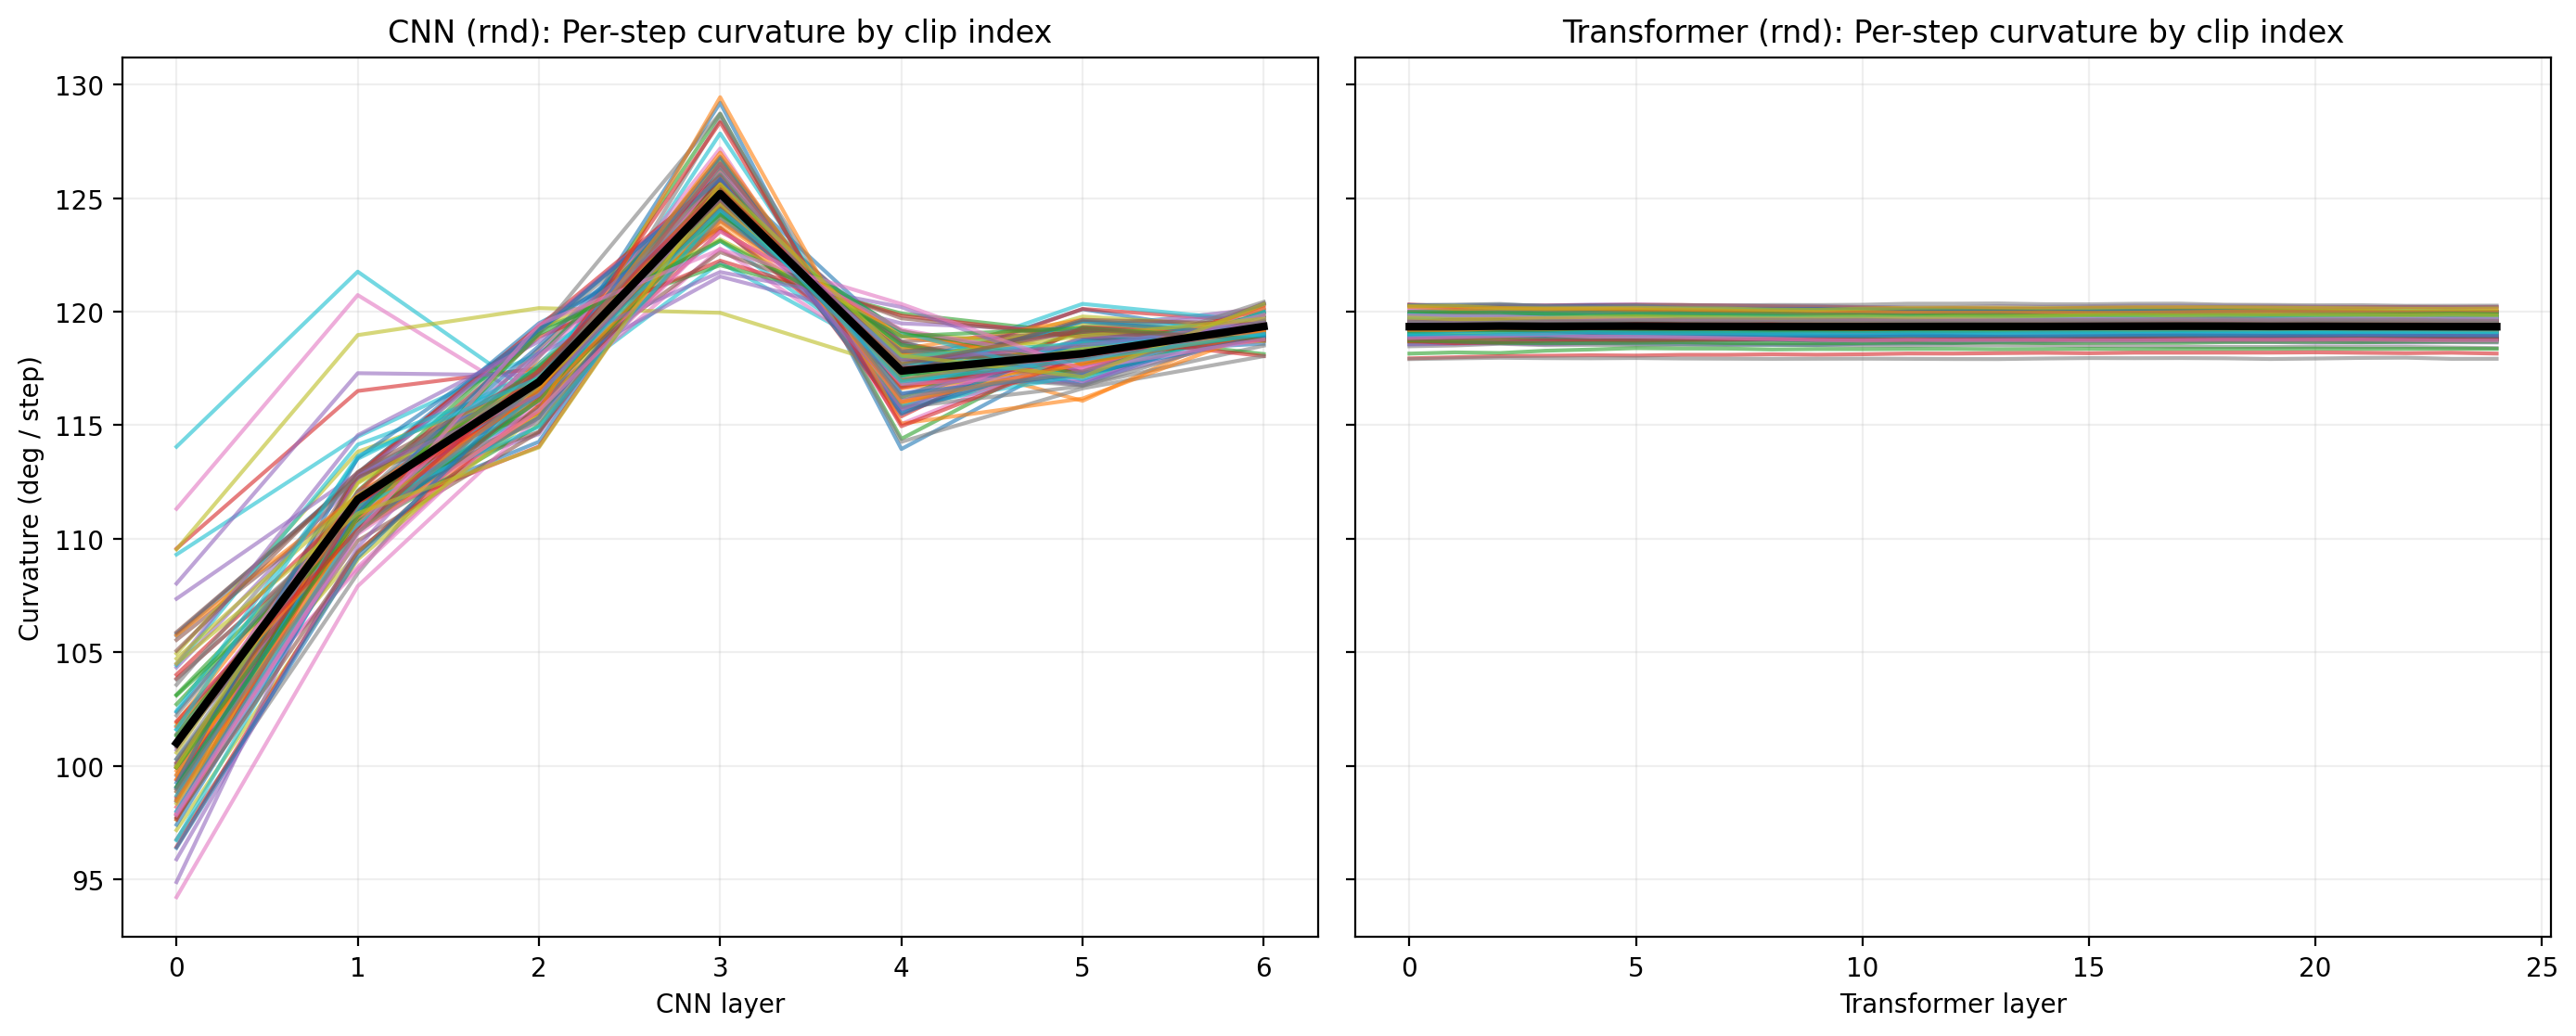

In [128]:
HOP_S = 0.02 # this parameter is only needed when computing per second curvature.
# SAVE_PDF = "wavlm_curvature_snippets_byindex.pdf"

all_cnn_per_step_rnd, all_tr_per_step_rnd = [], []
clip_labels = []  # numeric clip indices for legend

# ---- loop over all snippets ----
for si, wav_path in enumerate(snippet_paths):
    wav = load_mono_resampled(wav_path, 16000)
    inputs = feature_extractor(wav.numpy(), sampling_rate=16000, return_tensors="pt")
    inputs = {k: v.to(next(rnd.parameters()).device) for k, v in inputs.items()}

    cnn_rnd, tr_rnd = collect_wavlm_activations(rnd, inputs, hook_point="layer")

    cnn_per_step_curv = []
    for li in range(len(cnn_rnd)):
        X = cnn_rnd[li][1].squeeze(0).numpy()
        max_duration_sec = (X.shape[0] - 1) * HOP_S
        per_step, _, _ = avg_curvature(X, max_duration_sec)
        cnn_per_step_curv.append(per_step)

    tr_per_step_curv = []
    for li in range(len(tr_rnd)):
        X = tr_rnd[li].squeeze(0).numpy()
        max_duration_sec = (X.shape[0] - 1) * HOP_S
        per_step, _, _ = avg_curvature(X, max_duration_sec)
        tr_per_step_curv.append(per_step)

    all_cnn_per_step_rnd.append(np.asarray(cnn_per_step_curv))
    all_tr_per_step_rnd.append(np.asarray(tr_per_step_curv))

    # extract just the numeric index from the filename (e.g., "000" from "wheretheressmoke_000.wav")
    filename = os.path.basename(wav_path)
    match = re.search(r'_(\d+)\.wav$', filename)
    clip_labels.append(match.group(1) if match else str(si))

    print(f"[{si+1}/{len(snippet_paths)}] processed clip {clip_labels[-1]}")

# ---- stack arrays ----
cnn_mat_rnd = np.vstack(all_cnn_per_step_rnd)
tr_mat_rnd  = np.vstack(all_tr_per_step_rnd)

cnn_L, tr_L = cnn_mat_rnd.shape[1], tr_mat_rnd.shape[1]
x_cnn = np.arange(cnn_L)
x_tr  = np.arange(tr_L)

# ---- plotting ----
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# --- CNN subplot ---
for i in range(cnn_mat_rnd.shape[0]):
    axs[0].plot(x_cnn, cnn_mat_rnd[i], linewidth=1.5, alpha=0.6, label=clip_labels[i])
axs[0].plot(x_cnn, np.nanmean(cnn_mat_rnd, axis=0), linewidth=3, color="black", label="Mean curvature")
axs[0].set_title("CNN (rnd): Per-step curvature by clip index")
axs[0].set_xlabel("CNN layer")
axs[0].set_ylabel("Curvature (deg / step)")
axs[0].grid(alpha=0.2)

# --- Transformer subplot ---
for i in range(tr_mat_rnd.shape[0]):
    axs[1].plot(x_tr, tr_mat_rnd[i], linewidth=1.5, alpha=0.6, label=clip_labels[i])
axs[1].plot(x_tr, np.nanmean(tr_mat_rnd, axis=0), linewidth=3, color="black", label="Mean curvature")
axs[1].set_title("Transformer (rnd): Per-step curvature by clip index")
axs[1].set_xlabel("Transformer layer")
axs[1].grid(alpha=0.2)

# --- Combined legend outside both panels ---
# handles, labels = axs[1].get_legend_handles_labels()
# fig.legend(handles, labels, loc="upper center", ncol=8, fontsize=7,
#            bbox_to_anchor=(0.5, 1.05), frameon=False, title="Clip Index")

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(SAVE_PDF, format="pdf", bbox_inches="tight")
plt.show()

##### Relationship between sentence properties (surprisal, word rate, word coverage) and curvature

In [64]:
# Load sentence properties 
import json
with open("./data/audios/10s_clips/gpt2_sentence_surprisal.json", "r") as f:
    word_coverage_per_sent = json.load(f)
sent_surprisal = np.array([sent["sentence_surprisal_mean_bits"] for sent in word_coverage_per_sent], dtype=float)
sent_word_coverage = np.load("./data/audios/10s_clips/word_coverage_per_sentence.npy")
sent_word_rate = np.load("./data/audios/10s_clips/word_rate_per_sentence.npy")

Surprisal:

In [ ]:
from scipy.stats import pearsonr

mean_curv_tr_layers = np.mean(tr_mat, axis=1)
delta_curv_tr = tr_mat[:, 0] - tr_mat[:, -1]
curv_tr_last_layer = tr_mat[:, -1]
curv_tr_first_layer = tr_mat[:, 0]
curv_cnn_first_layer = cnn_mat[:, 0]

def plot_with_fit(ax, x, y, xlabel, ylabel, title, color="#658AAD"):
    # scatter
    ax.scatter(x, y, s=20, color=color, alpha=0.7, edgecolor="white", linewidth=0.5)

    # best-fit line
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    x_line = np.linspace(min(x), max(x), 100)
    ax.plot(x_line, p(x_line), color="black", linestyle="--", linewidth=1)

    # correlation coefficient
    r, pval = pearsonr(x, y)
    ax.text(
        0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes,
        ha="left", va="top", fontsize=9,
        bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="gray", alpha=0.8)
    )

    # labels & title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.grid(True, linestyle="--", alpha=0.3)

fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
axes = axes.flatten()

# 1️⃣ Δ curvature
plot_with_fit(axes[0], sent_surprisal, delta_curv_tr,
              "Sentence surprisal (bits)", "Δ curvature (straightening)",
              "Surprisal vs Δ curvature")

# 2️⃣ Mean transformer curvature
plot_with_fit(axes[1], sent_surprisal, mean_curv_tr_layers,
              "Sentence surprisal (bits)", "Mean curvature (Transformer)",
              "Surprisal vs mean Transformer curvature")

# 3️⃣ CNN first layer
plot_with_fit(axes[2], sent_surprisal, curv_cnn_first_layer,
              "Sentence surprisal (bits)", "CNN curvature (first layer)",
              "Surprisal vs CNN first layer curvature")

# 4️⃣ Transformer first layer
plot_with_fit(axes[3], sent_surprisal, curv_tr_first_layer,
              "Sentence surprisal (bits)", "Transformer curvature (first layer)",
              "Surprisal vs Transformer first layer curvature")

# 5️⃣ Transformer last layer
plot_with_fit(axes[4], sent_surprisal, curv_tr_last_layer,
              "Sentence surprisal (bits)", "Transformer curvature (last layer)",
              "Surprisal vs Transformer last layer curvature")

axes[5].axis("off")

plt.tight_layout()
plt.show()


Word rate:

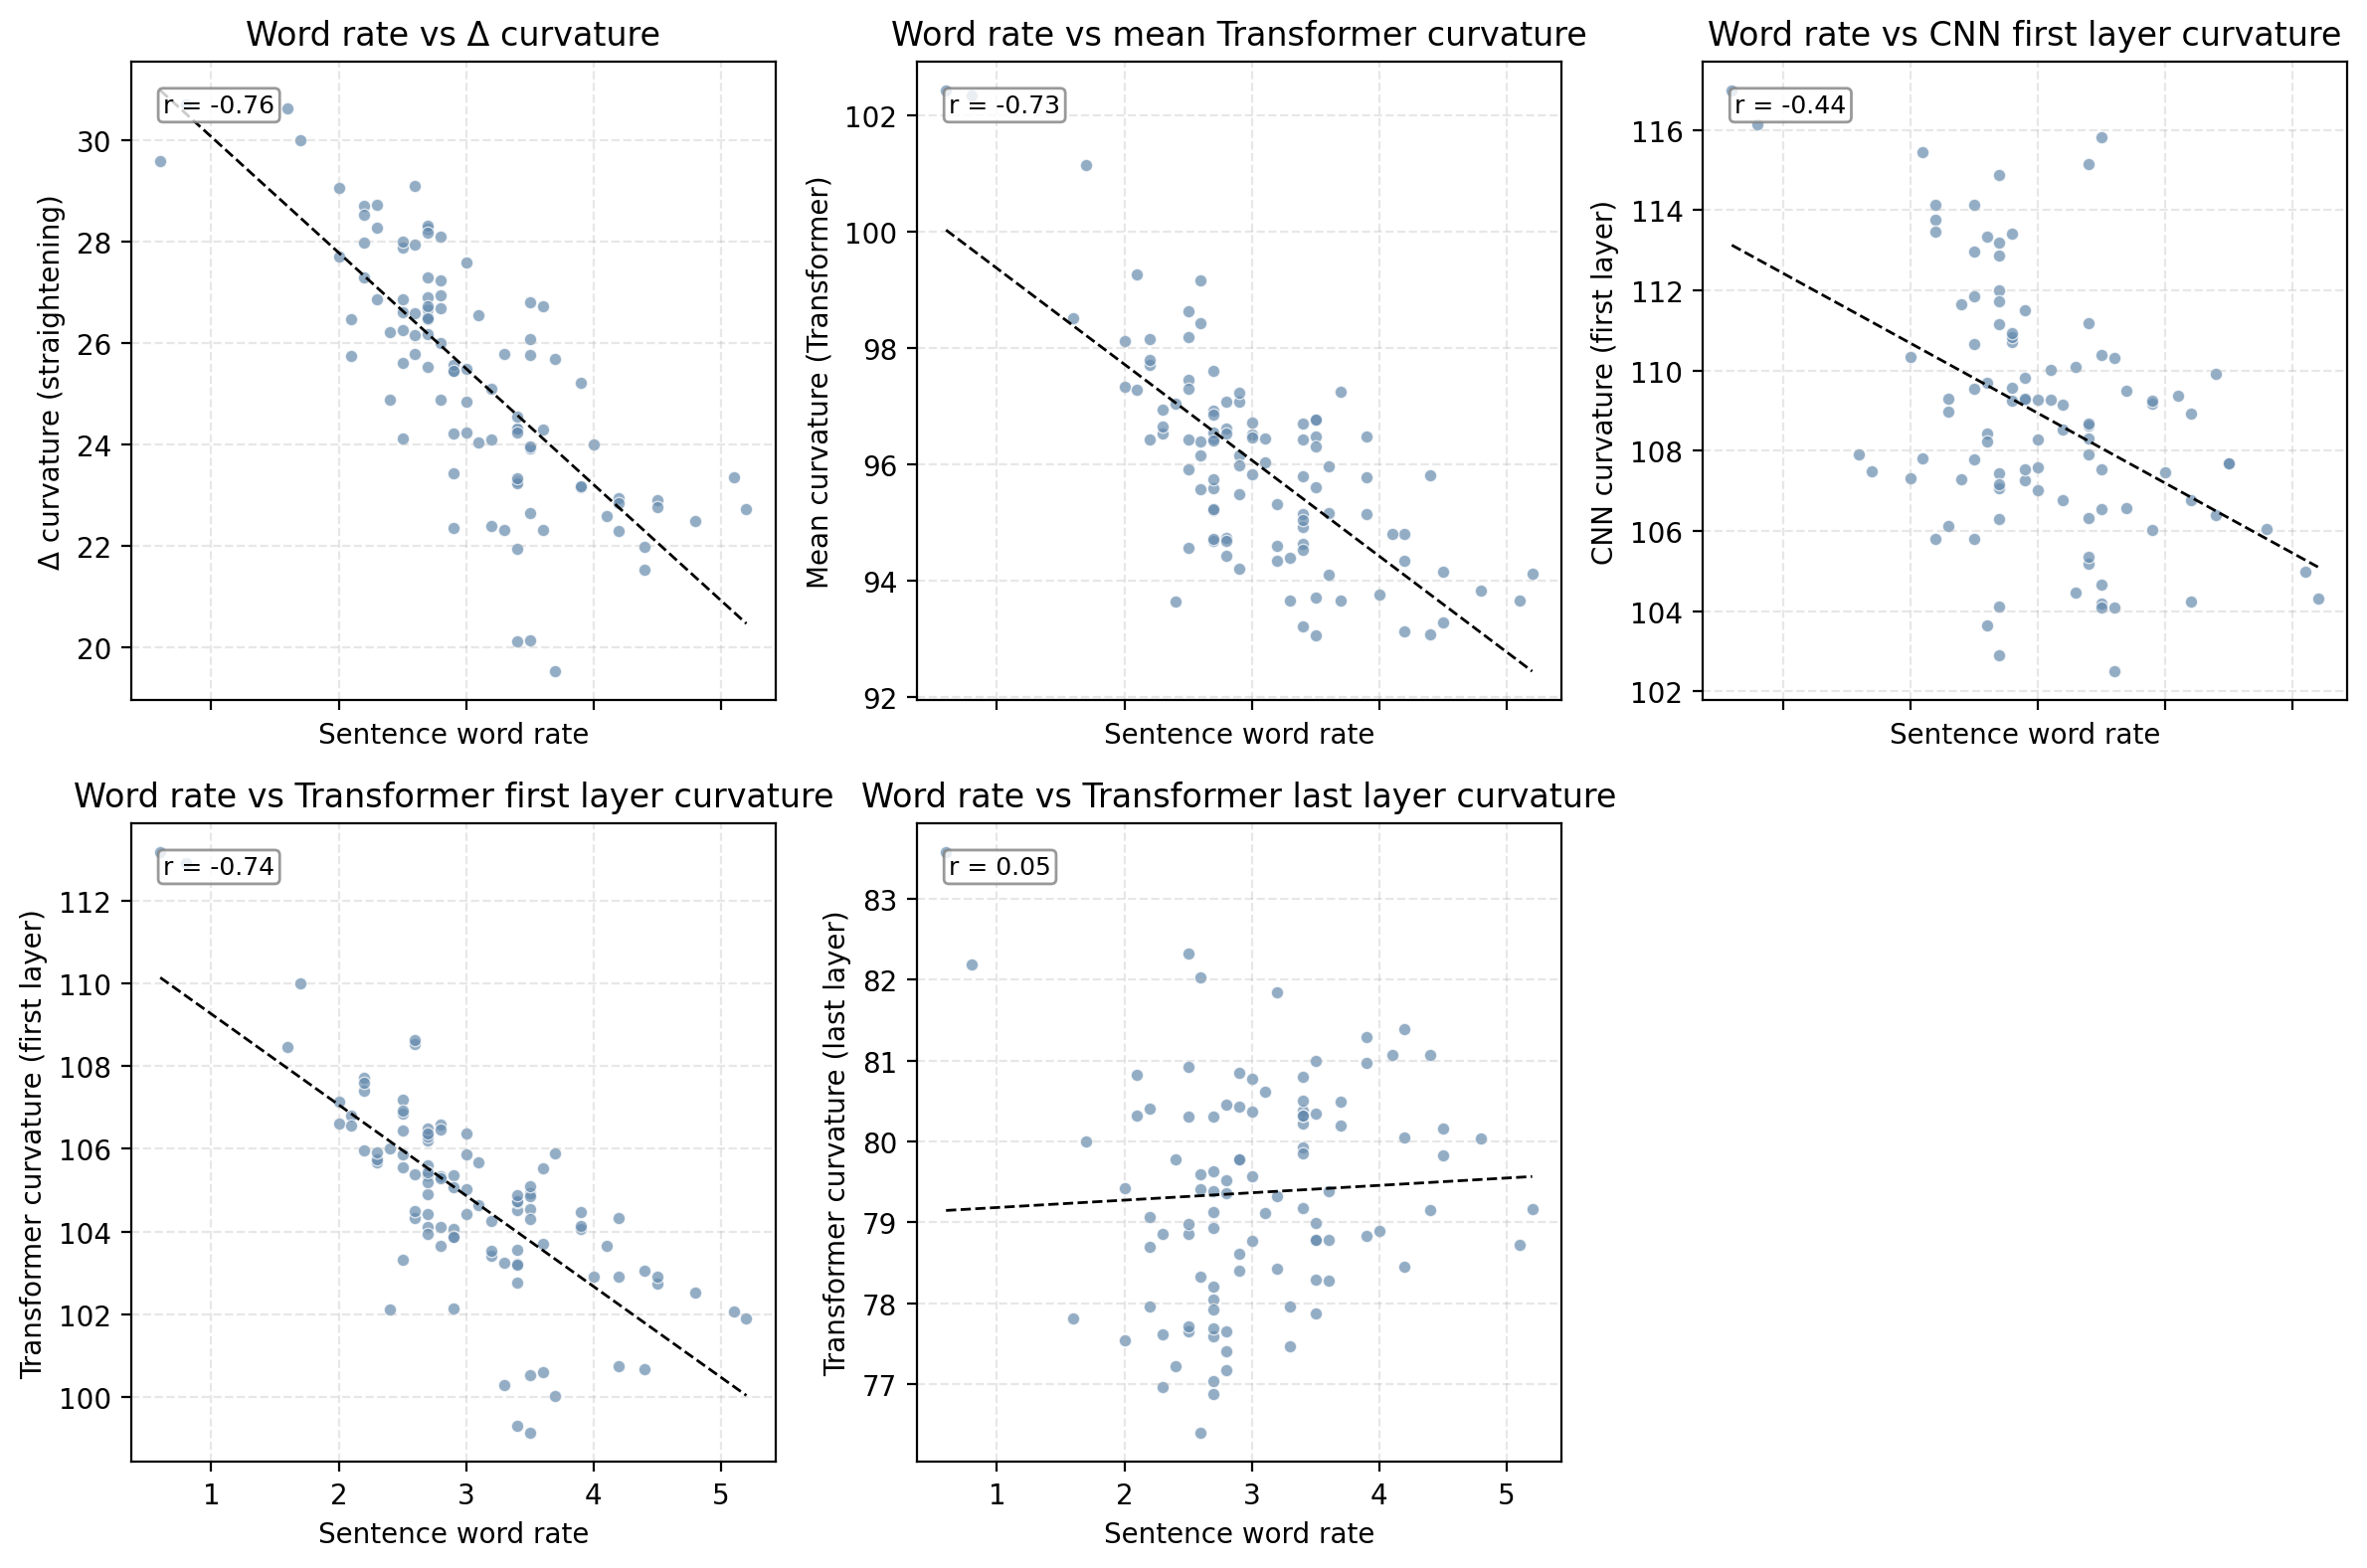

In [117]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
axes = axes.flatten()

# 1️⃣ Δ curvature
plot_with_fit(axes[0], sent_word_rate, delta_curv_tr,
              "Sentence word rate", "Δ curvature (straightening)",
              "Word rate vs Δ curvature")

# 2️⃣ Mean transformer curvature
plot_with_fit(axes[1], sent_word_rate, mean_curv_tr_layers,
              "Sentence word rate", "Mean curvature (Transformer)",
              "Word rate vs mean Transformer curvature")

# 3️⃣ CNN first layer
plot_with_fit(axes[2], sent_word_rate, curv_cnn_first_layer,
              "Sentence word rate", "CNN curvature (first layer)",
              "Word rate vs CNN first layer curvature")

# 4️⃣ Transformer first layer
plot_with_fit(axes[3], sent_word_rate, curv_tr_first_layer,
              "Sentence word rate", "Transformer curvature (first layer)",
              "Word rate vs Transformer first layer curvature")

# 5️⃣ Transformer last layer
plot_with_fit(axes[4], sent_word_rate, curv_tr_last_layer,
              "Sentence word rate", "Transformer curvature (last layer)",
              "Word rate vs Transformer last layer curvature")

axes[5].axis("off")

plt.tight_layout()
plt.show()


Word coverage

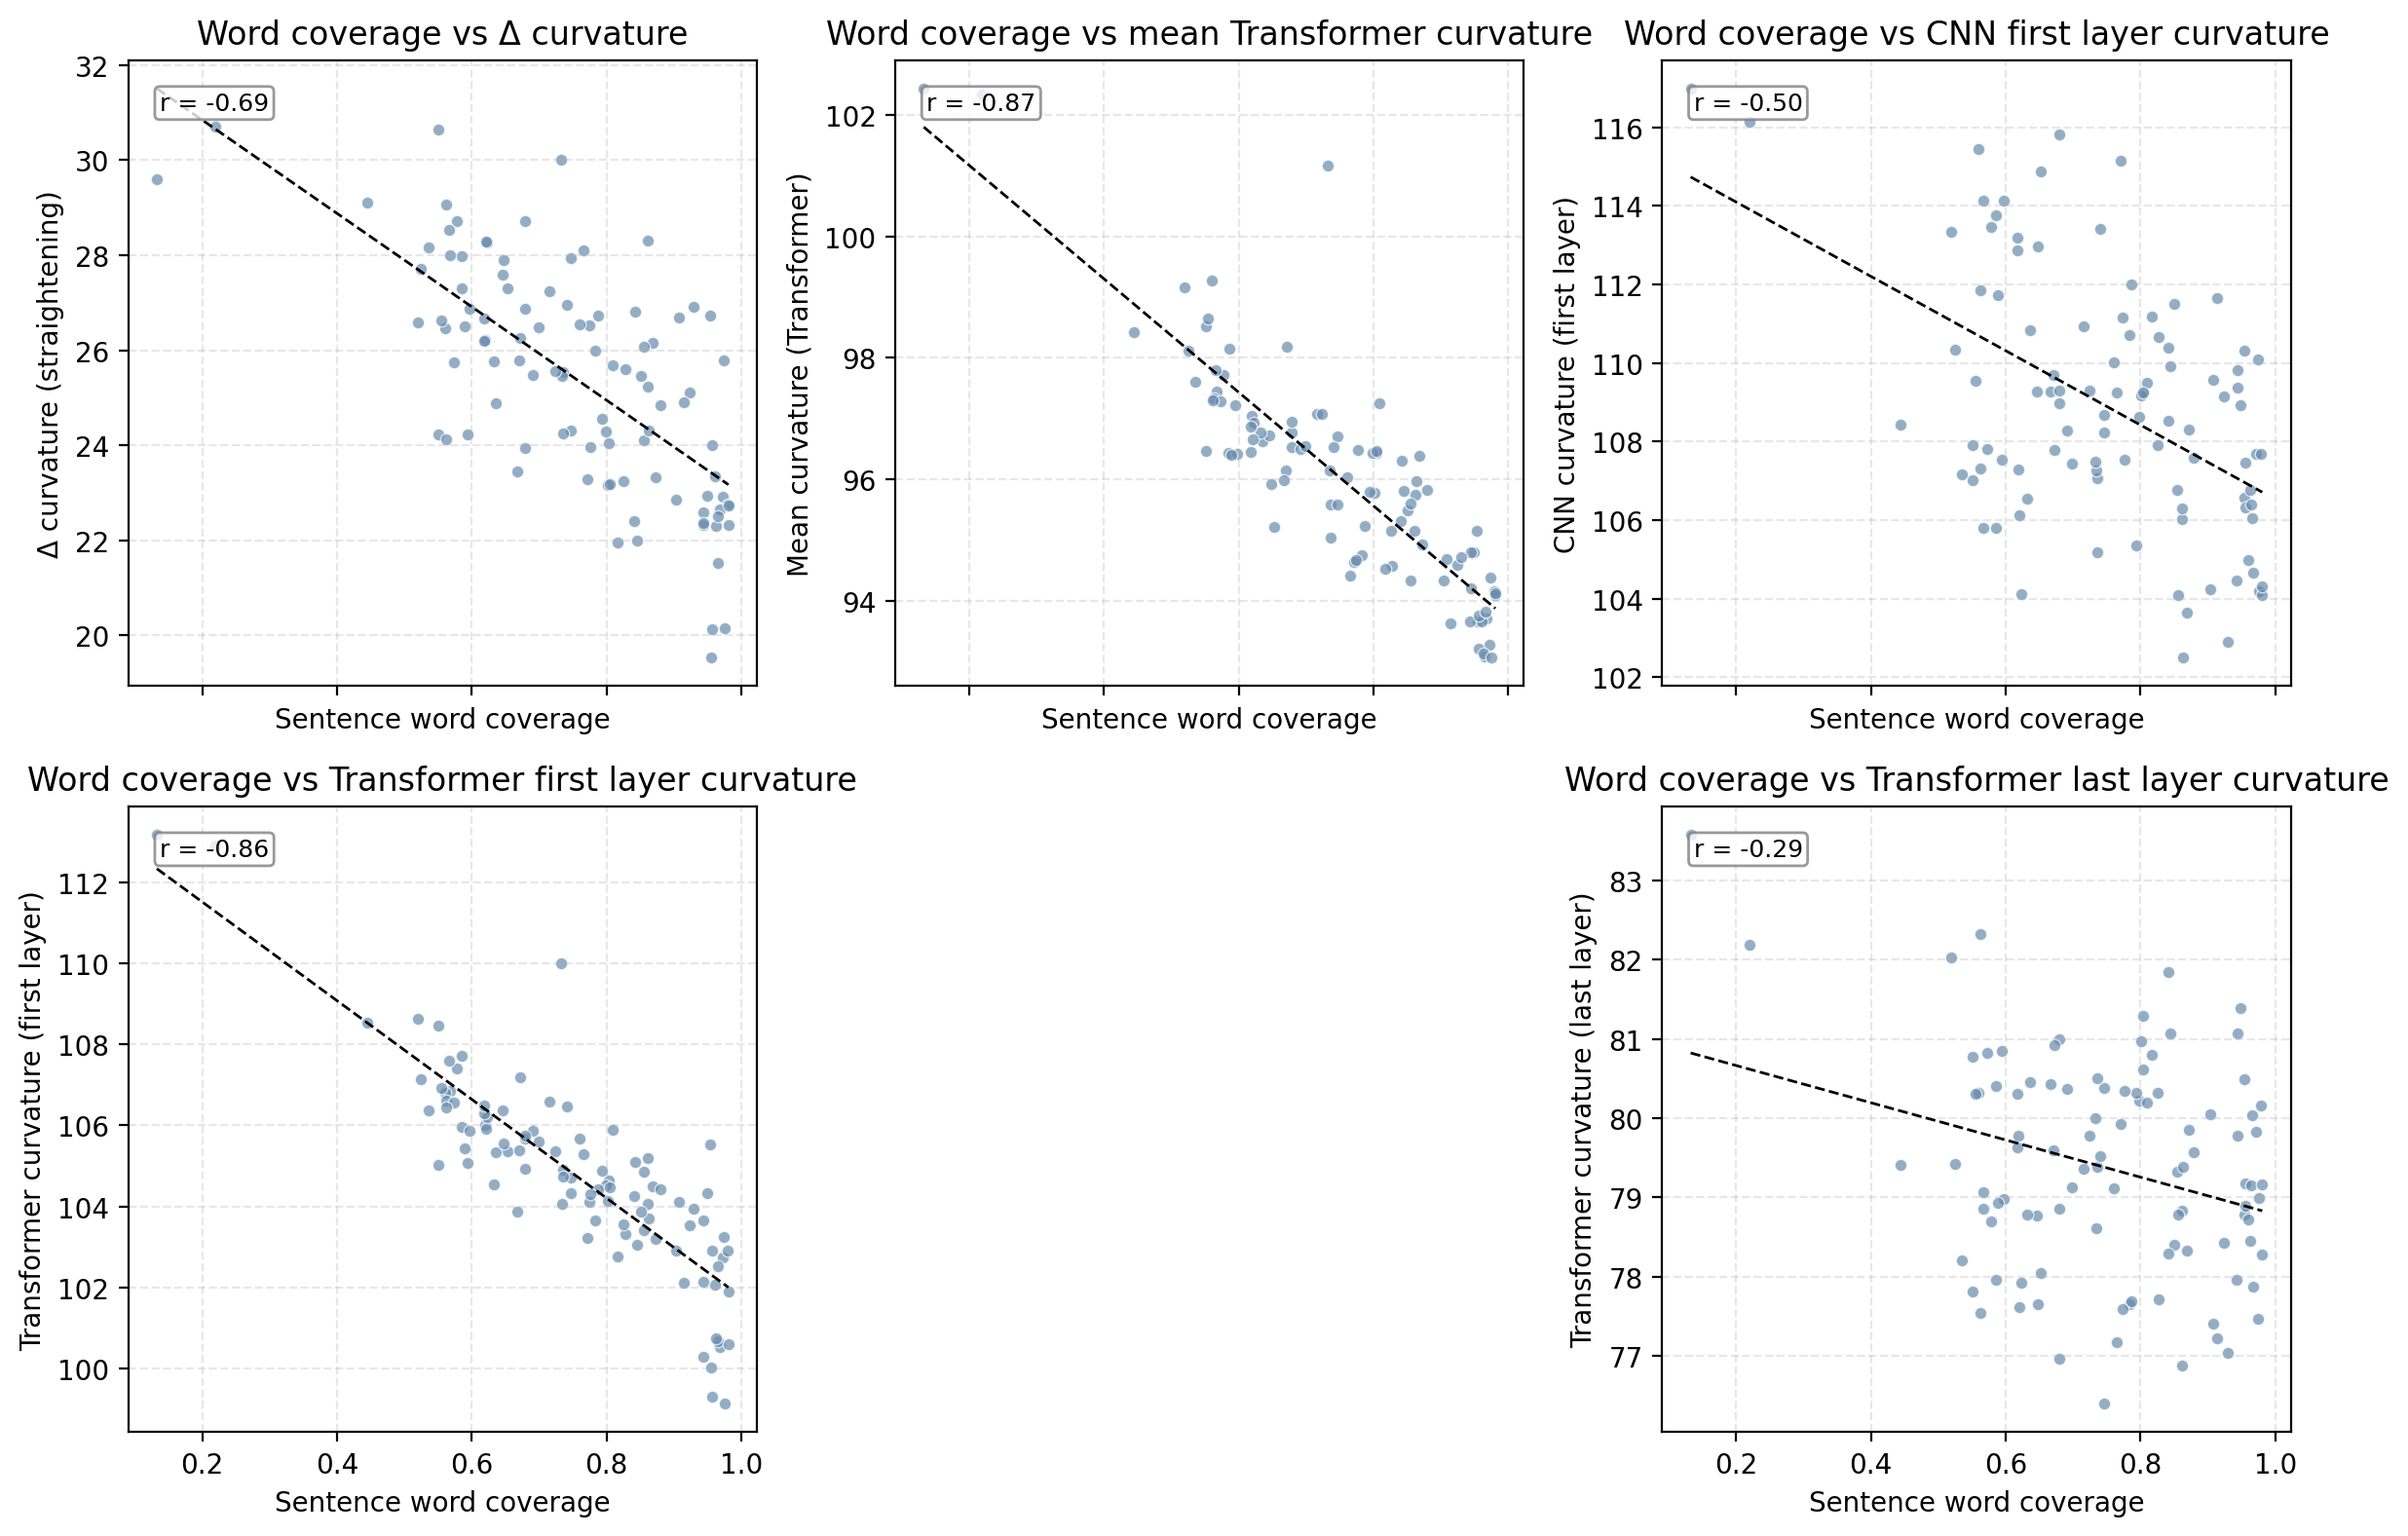

In [119]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8), sharex=True, sharey=False)
axes = axes.flatten()

# 1️⃣ Δ curvature
plot_with_fit(axes[0], sent_word_coverage, delta_curv_tr,
              "Sentence word coverage", "Δ curvature (straightening)",
              "Word coverage vs Δ curvature")

# 2️⃣ Mean transformer curvature
plot_with_fit(axes[1], sent_word_coverage, mean_curv_tr_layers,
              "Sentence word coverage", "Mean curvature (Transformer)",
              "Word coverage vs mean Transformer curvature")

# 3️⃣ CNN first layer
plot_with_fit(axes[2], sent_word_coverage, curv_cnn_first_layer,
              "Sentence word coverage", "CNN curvature (first layer)",
              "Word coverage vs CNN first layer curvature")

# 4️⃣ Transformer first layer
plot_with_fit(axes[3], sent_word_coverage, curv_tr_first_layer,
              "Sentence word coverage", "Transformer curvature (first layer)",
              "Word coverage vs Transformer first layer curvature")

# 5️⃣ Transformer last layer
plot_with_fit(axes[5], sent_word_coverage, curv_tr_last_layer,
              "Sentence word coverage", "Transformer curvature (last layer)",
              "Word coverage vs Transformer last layer curvature")

axes[4].axis("off")

plt.tight_layout()
plt.show()

Correlations between sentence properties and curvature across layers

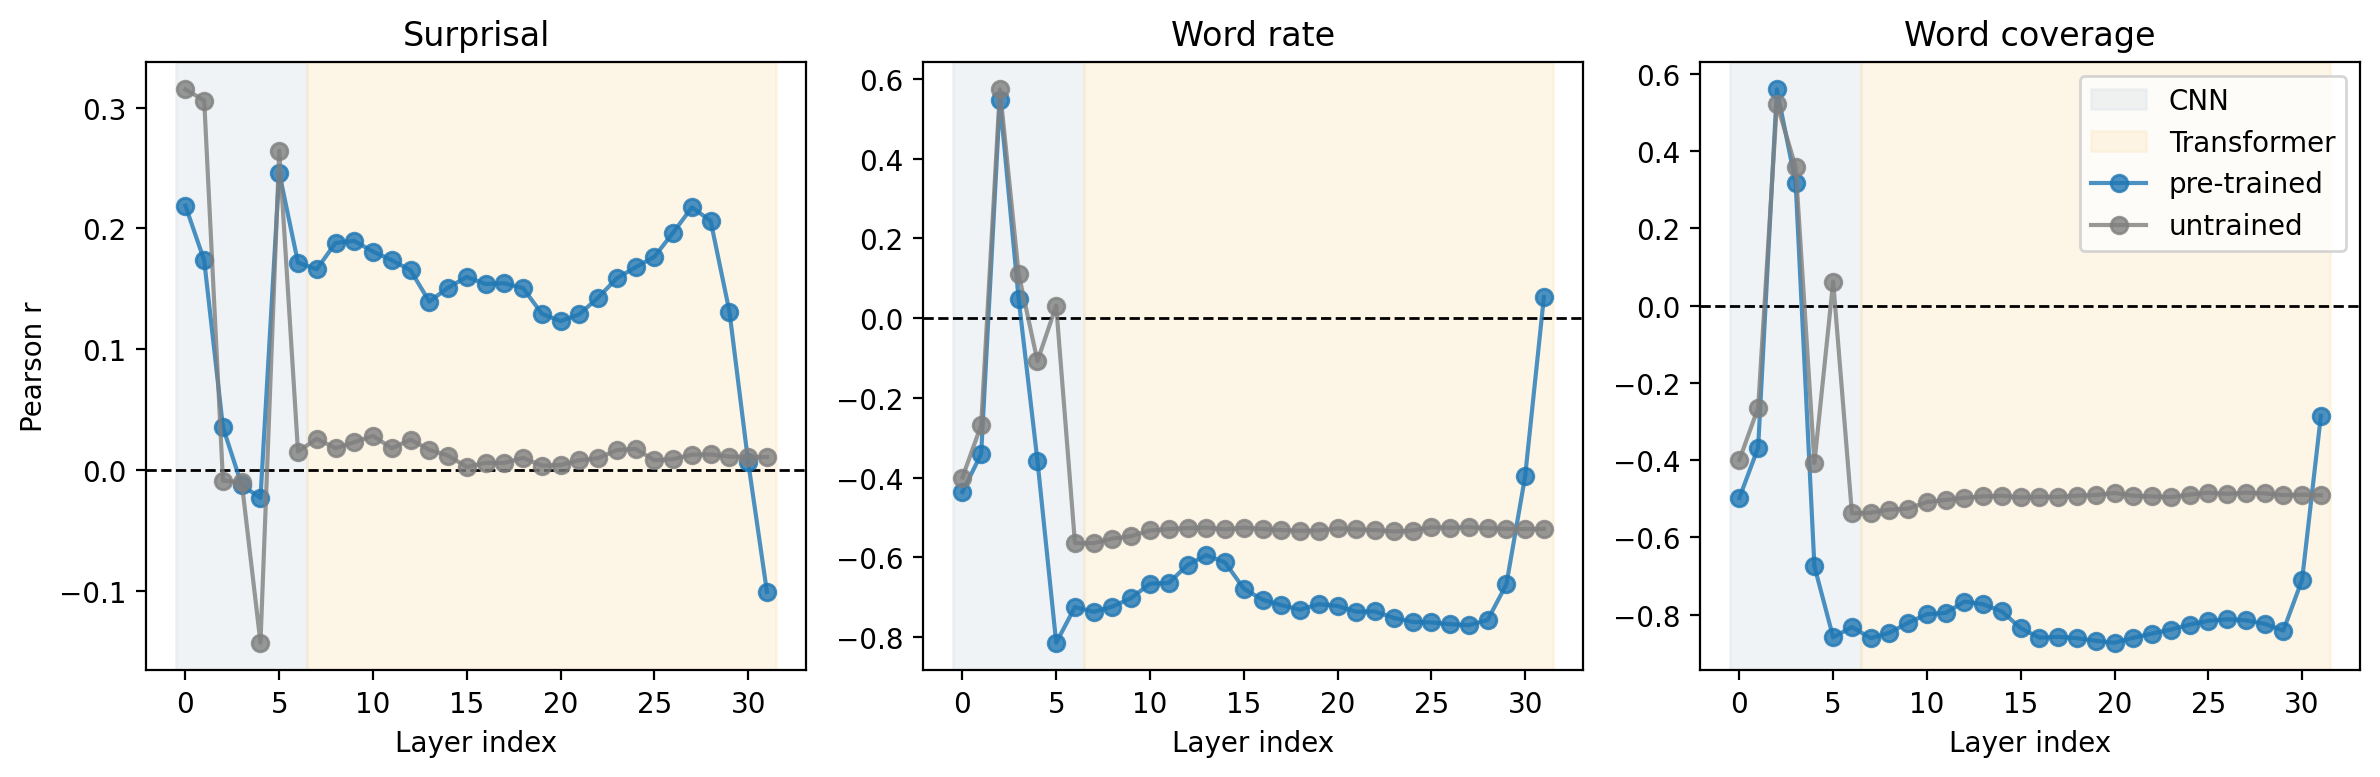

In [141]:
# Compute correlations
num_layers = cnn_mat.shape[1] + tr_mat.shape[1]
curv_mat = np.hstack((cnn_mat, tr_mat))
curv_mat_rnd = np.hstack((cnn_mat_rnd, tr_mat_rnd))

rs_surprisal, rs_word_rate, rs_word_cov = [], [], []
rnd_rs_surprisal, rnd_rs_word_rate, rnd_rs_word_cov = [], [], []

for layer_i in range(num_layers):
    # correlate with pre-trained model curvatures
    r_surprisal = np.corrcoef(sent_surprisal, curv_mat[:, layer_i])[0, 1]
    rs_surprisal.append(r_surprisal)
    r_word_rate = np.corrcoef(sent_word_rate, curv_mat[:, layer_i])[0, 1]
    rs_word_rate.append(r_word_rate)
    r_word_cov = np.corrcoef(sent_word_coverage, curv_mat[:, layer_i])[0, 1]
    rs_word_cov.append(r_word_cov)

    # correlate with untrained model curvatures
    rnd_r_surprisal = np.corrcoef(sent_surprisal, curv_mat_rnd[:, layer_i])[0, 1]
    rnd_rs_surprisal.append(rnd_r_surprisal)
    rnd_r_word_rate = np.corrcoef(sent_word_rate, curv_mat_rnd[:, layer_i])[0, 1]
    rnd_rs_word_rate.append(rnd_r_word_rate)
    rnd_r_word_cov = np.corrcoef(sent_word_coverage, curv_mat_rnd[:, layer_i])[0, 1]
    rnd_rs_word_cov.append(rnd_r_word_cov)

# Plotting
cnn_layers = cnn_mat.shape[1]
transformer_layers = tr_mat.shape[1]
layer_idx = np.arange(num_layers)

# Create figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=False)

# Common layer boundary line
for ax in axes:
    ax.axvspan(-0.5, cnn_layers - 0.5, color="#DAE2E6D2", alpha=0.4, label="CNN")        
    ax.axvspan(cnn_layers - 0.5, num_layers - 0.5, color="#FCE8C2DA", alpha=0.4, label="Transformer")  
    # ax.axvline(cnn_layers - 0.5, color="black", linestyle="--", linewidth=1)
    ax.axhline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xticks(np.arange(0, num_layers, 5))
    ax.set_xlabel("Layer index")

# Surprisal
axes[0].plot(layer_idx, rs_surprisal, marker="o", label="pre-trained", color="tab:blue", alpha=0.8)
axes[0].plot(layer_idx, rnd_rs_surprisal, marker="o", label="untrained", color="tab:gray", alpha=0.8)
axes[0].set_ylabel("Pearson r")
axes[0].set_title("Surprisal")


# Word rate
axes[1].plot(layer_idx, rs_word_rate, marker="o", label="pre-trained", color="tab:blue", alpha=0.8)
axes[1].plot(layer_idx, rnd_rs_word_rate, marker="o", label="untrained", color="tab:gray", alpha=0.8)
axes[1].set_title("Word rate")


# Word coverage
axes[2].plot(layer_idx, rs_word_cov, marker="o", label="pre-trained", color="tab:blue", alpha=0.8)
axes[2].plot(layer_idx, rnd_rs_word_cov, marker="o", label="untrained", color="tab:gray", alpha=0.8)
axes[2].set_title("Word coverage")
axes[2].legend()

plt.tight_layout()
plt.show()


#### Get autocorrelation functions for each layer, averaged across all units (get timescale)

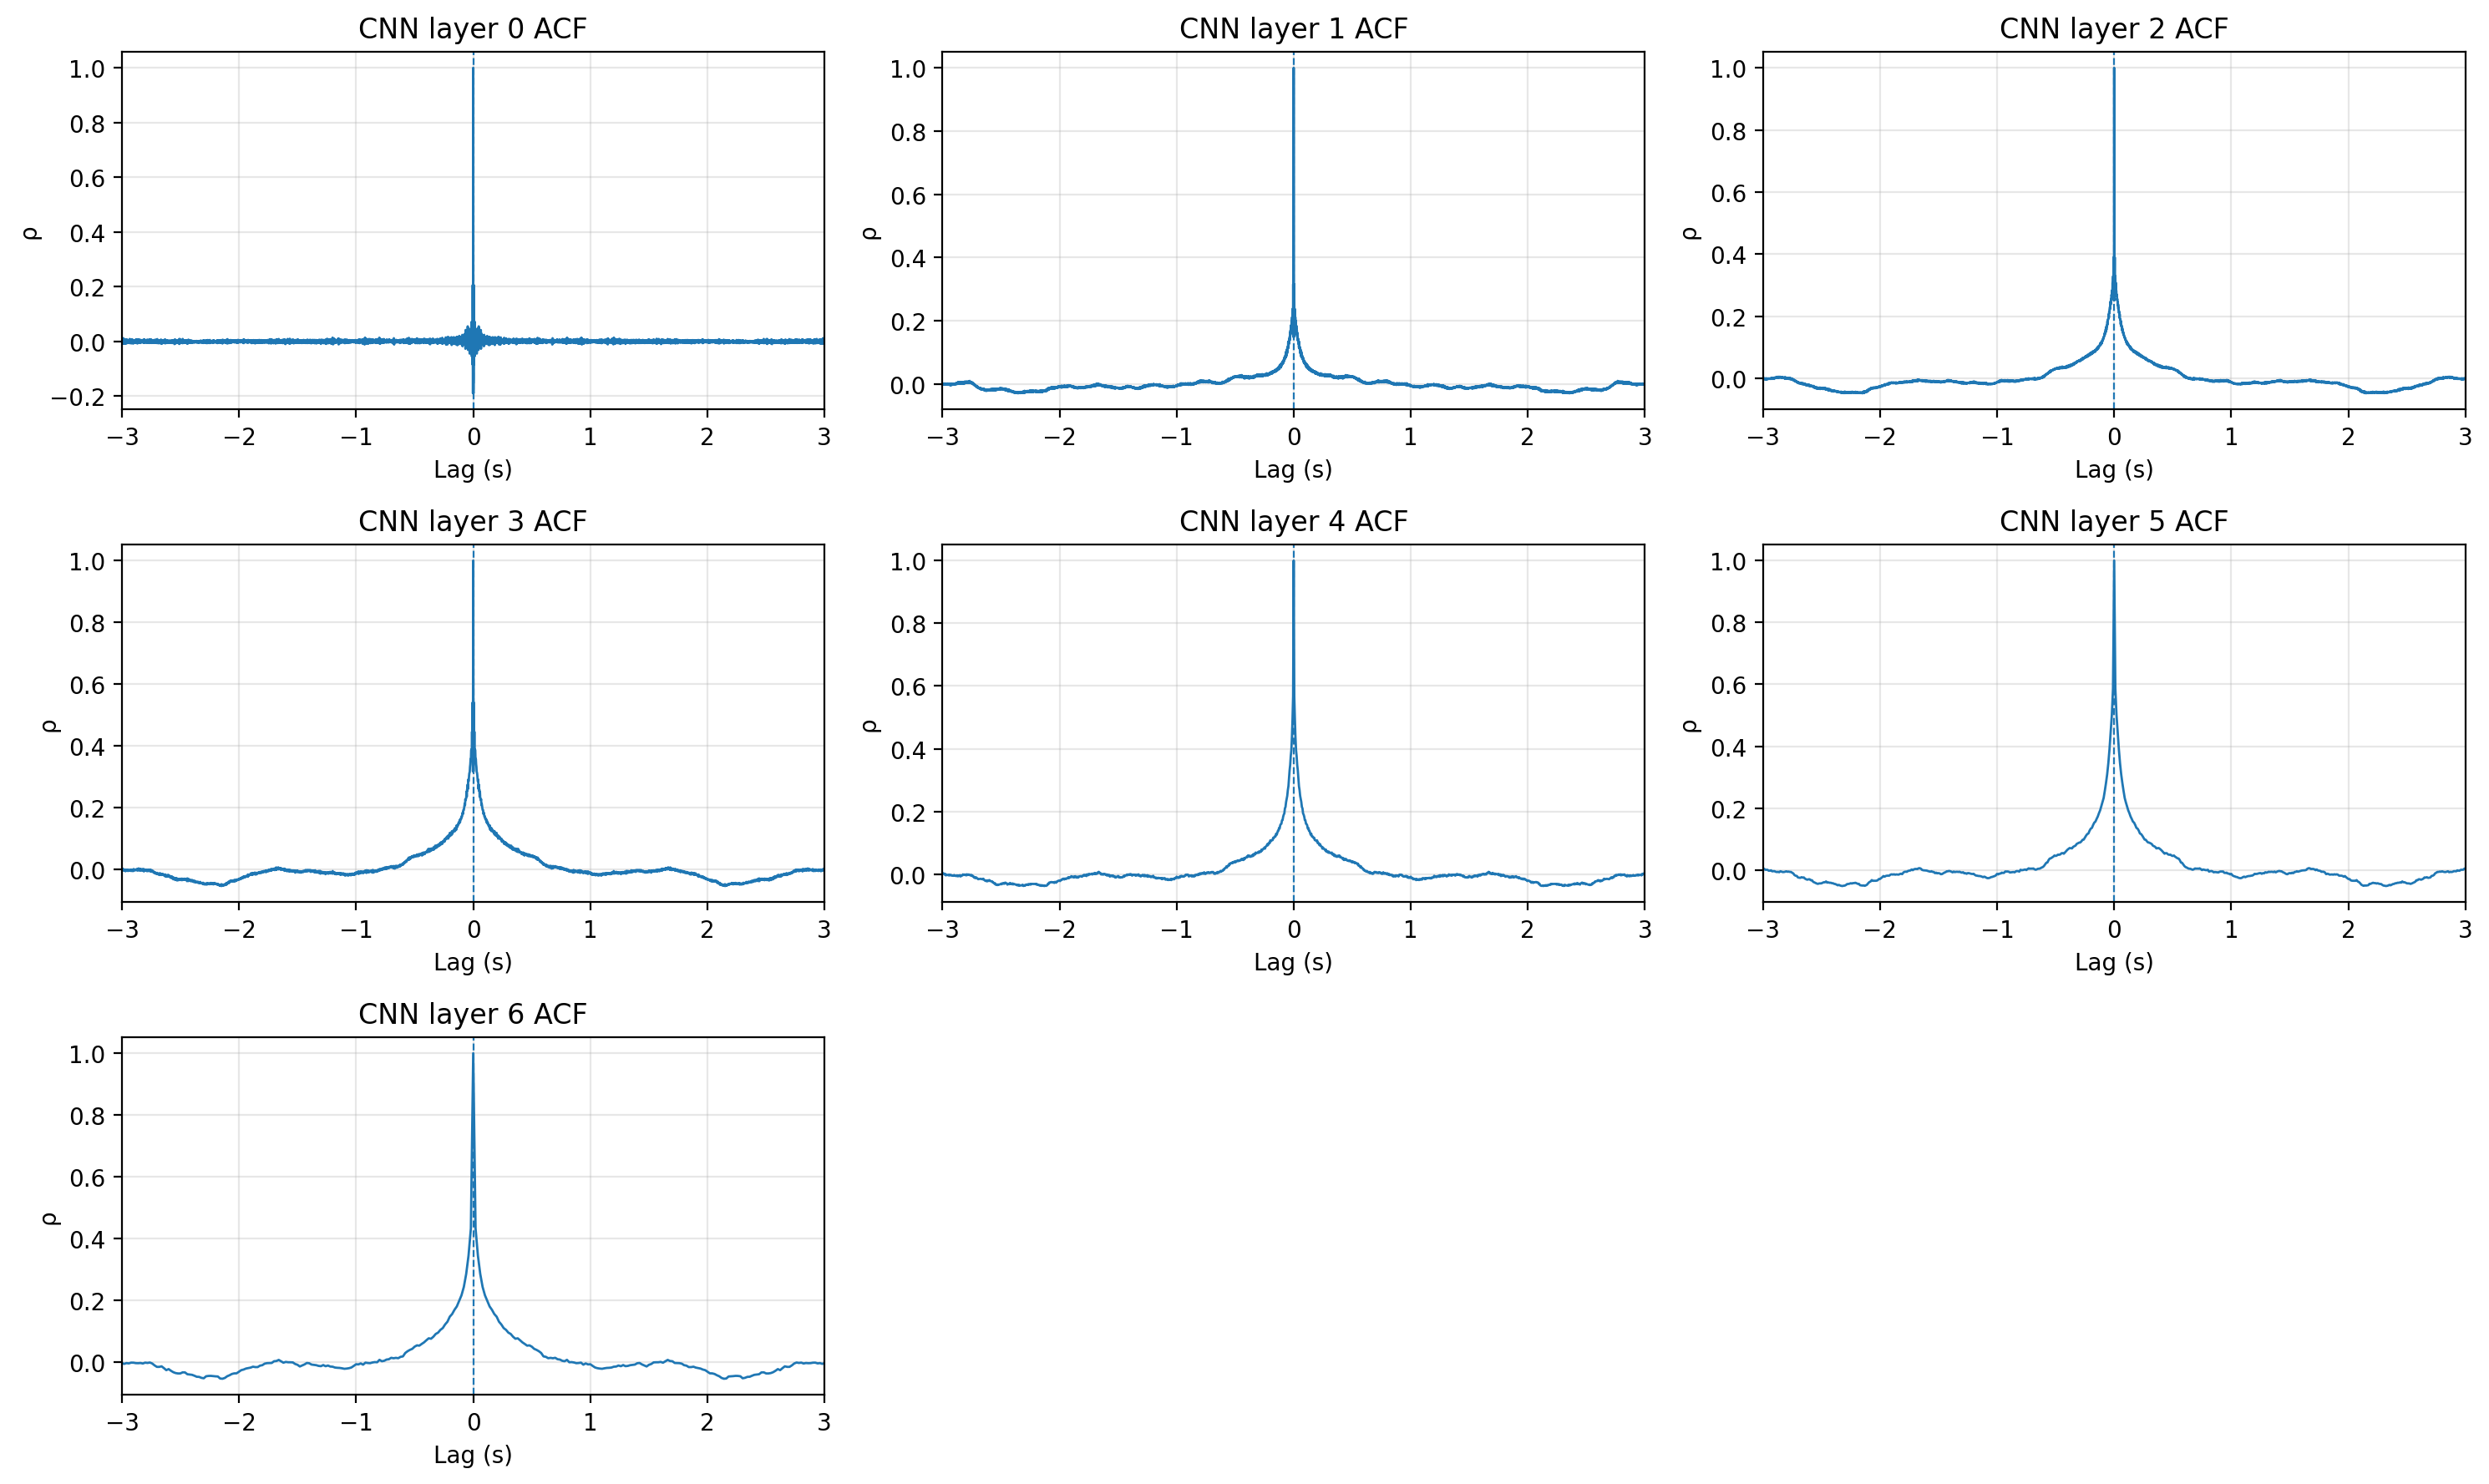

In [44]:
# CNN layers
# change cnn_pre to cnn_rnd to see how randomly initialized weights behave 

sr = 16000.0
duration_sec = max_duration_sec  
max_sec = 3                                         # show ±max_sec on x-axis

cnn_ac = []   
cnn_t  = []   # lags axis (in seconds)

for cnn_layer in range(len(cnn_pre)):
    # Layer activations: [T_l, C]
    X = cnn_pre[cnn_layer][1].cpu().numpy()
    T_l = X.shape[0]

    # Per-unit full autocorr (demeaned, normalized at 0-lag)
    ac_list = []
    for u in range(X.shape[1]):
        x = X[:, u]
        x = x - x.mean()
        ac = signal.correlate(x, x, mode="full")
        mid = ac.size // 2
        denom = ac[mid]
        ac_list.append(ac / denom)

    ac_stack = np.stack(ac_list)         
    ac_avg   = ac_stack.mean(axis=0)     

    # Full lag axis in seconds (negative..positive)
    lags = signal.correlation_lags(T_l, T_l, mode="full")  
    fps_l = T_l / duration_sec
    t_sec = lags / fps_l

    # # Truncate to the same duration window for all layers
    # keep = np.abs(t_sec) <= max_sec
    # cnn_ac.append(ac_avg[keep])
    # cnn_t.append(t_sec[keep])
    cnn_ac.append(ac_avg)
    cnn_t.append(t_sec)

# Plot
n_layers = len(cnn_ac)
ncols = 3
nrows = math.ceil(n_layers / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows), squeeze=False)

for i, ax in enumerate(axes.flat):
    if i >= n_layers:
        ax.axis('off')
        continue
    t = cnn_t[i]
    ac = cnn_ac[i]
    ax.plot(t, ac, linewidth=1)
    ax.set_xlim(-max_sec, max_sec)
    ax.set_title(f'CNN layer {i} ACF')
    ax.set_xlabel('Lag (s)')
    ax.set_ylabel('ρ')
    ax.axvline(0, linestyle='--', linewidth=0.8)
    ax.grid(True, alpha=0.3)

fig.tight_layout()


Quantify ACF with tau_int (area under ACF curve)

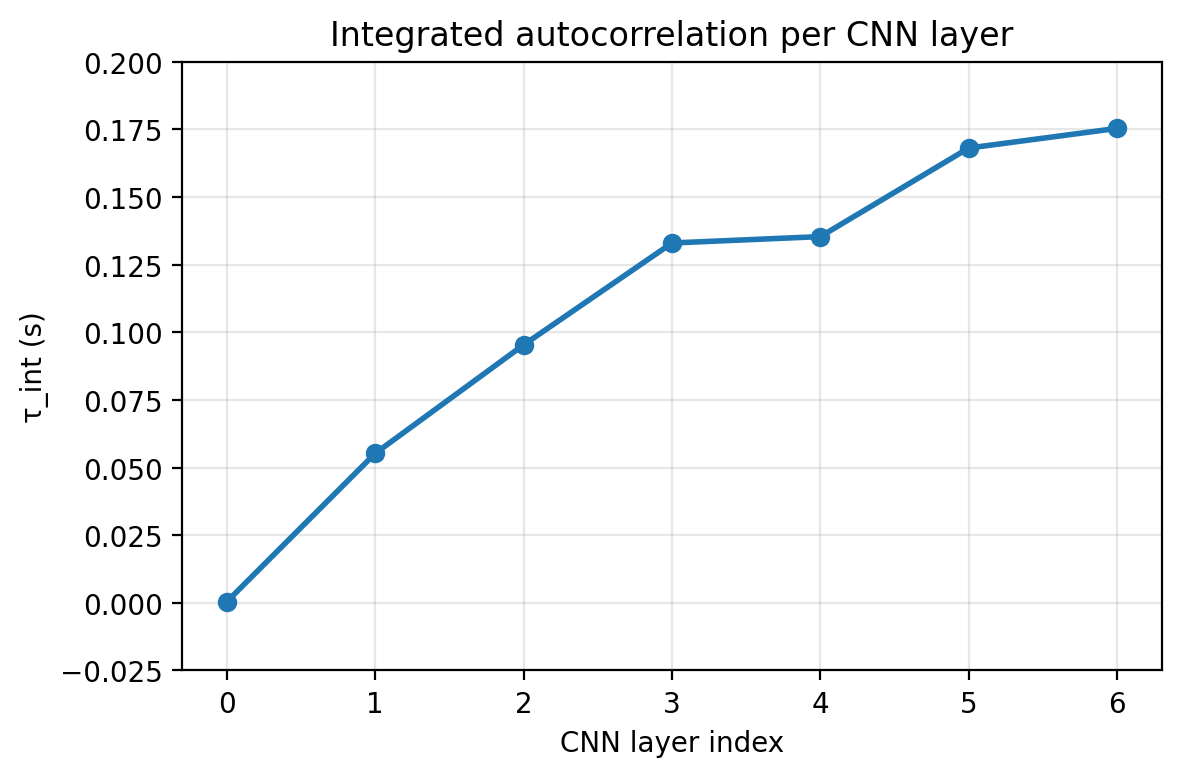

In [45]:
def integrated_autocorr_time(rho_pos, dt=1.0, method="ips"):
    """
    rho_pos: 1D array with rho_pos[0] = ρ(0) = 1, then positive lags only.
    """
    rho_pos = np.asarray(rho_pos)
    if method == "zero":
        # first strictly negative entry on the positive side (excluding 0-lag)
        neg_idx = np.argmax(rho_pos[1:] < 0)
        K = (neg_idx + 1) if np.any(rho_pos[1:] < 0) else (len(rho_pos) - 1)
        # sum ρ(Δt)..ρ(K*Δt)
        tau = dt * (1 + 2 * np.sum(rho_pos[1:K+1]))
    elif method == "ips":
        # Geyer's initial positive sequence on pairs (1,2), (3,4), ...
        s = []
        max_pair = (len(rho_pos) - 1) // 2
        for j in range(1, max_pair + 1):
            pair_sum = rho_pos[2*j-1] + rho_pos[2*j]
            if pair_sum > 0:
                s.append(pair_sum)
            else:
                break
        K = 2 * len(s)  # last included index on positive side
        tau = dt * (1 + 2 * np.sum(rho_pos[1:K+1]))
    else:
        raise ValueError("method must be 'zero' or 'ips'")
    return tau

taus_layer = []
for cnn_layer in range(len(cnn_pre)):
    dt = cnn_t[cnn_layer][1] - cnn_t[cnn_layer][0] # duration per timestep

    mid = np.argmin(np.abs(cnn_t[cnn_layer]))          # index closest to 0 s
    rho_pos = cnn_ac[cnn_layer][mid:]                  # [ρ(0), ρ(Δt), ρ(2Δt), ...]

    tau = integrated_autocorr_time(rho_pos, dt=dt, method="ips")
    taus_layer.append(tau)


# Plot
plt.figure(figsize=(6,4))
plt.plot(range(len(taus_layer)), taus_layer, marker='o', linewidth=2)
plt.xlabel("CNN layer index")
plt.ylabel("τ_int (s)")
plt.ylim([-0.025, 0.2])
plt.title("Integrated autocorrelation per CNN layer")
plt.grid(True, alpha=0.3)
plt.tight_layout()


In [42]:
# Transformer layers  
# change tr_pre to tr_rnd to observe how randomly initialized weights behave

# max_lag = 500                                        # show ±max_sec on x-axis

tr_ac = []   
tr_lag  = []   

for transformer_layer in range(len(tr_rnd)):
    # Layer activations: [T_l, C]
    X = tr_rnd[transformer_layer].cpu().numpy()
    # print(X.shape)
    T_l = X.shape[0]

    # Per-unit full autocorr (demeaned, normalized at 0-lag)
    ac_list = []
    for u in range(X.shape[1]):
        x = X[:, u]
        x = x - x.mean()
        ac = signal.correlate(x, x, mode="full")
        mid = ac.size // 2
        denom = ac[mid]
        ac_list.append(ac / denom)

    ac_stack = np.stack(ac_list)         
    ac_avg   = ac_stack.mean(axis=0)     

    # Full lag axis in seconds (negative..positive)
    lags = signal.correlation_lags(T_l, T_l, mode="full")  
    # fps_l = T_l / duration_sec
    # t_sec = lags / fps_l

    # Truncate to the same duration window for all layers
    # keep = np.abs(lags) <= max_lag
    # tr_ac.append(ac_avg[keep])
    # tr_lag.append(lags[keep])
    tr_ac.append(ac_avg)
    tr_lag.append(lags)
   

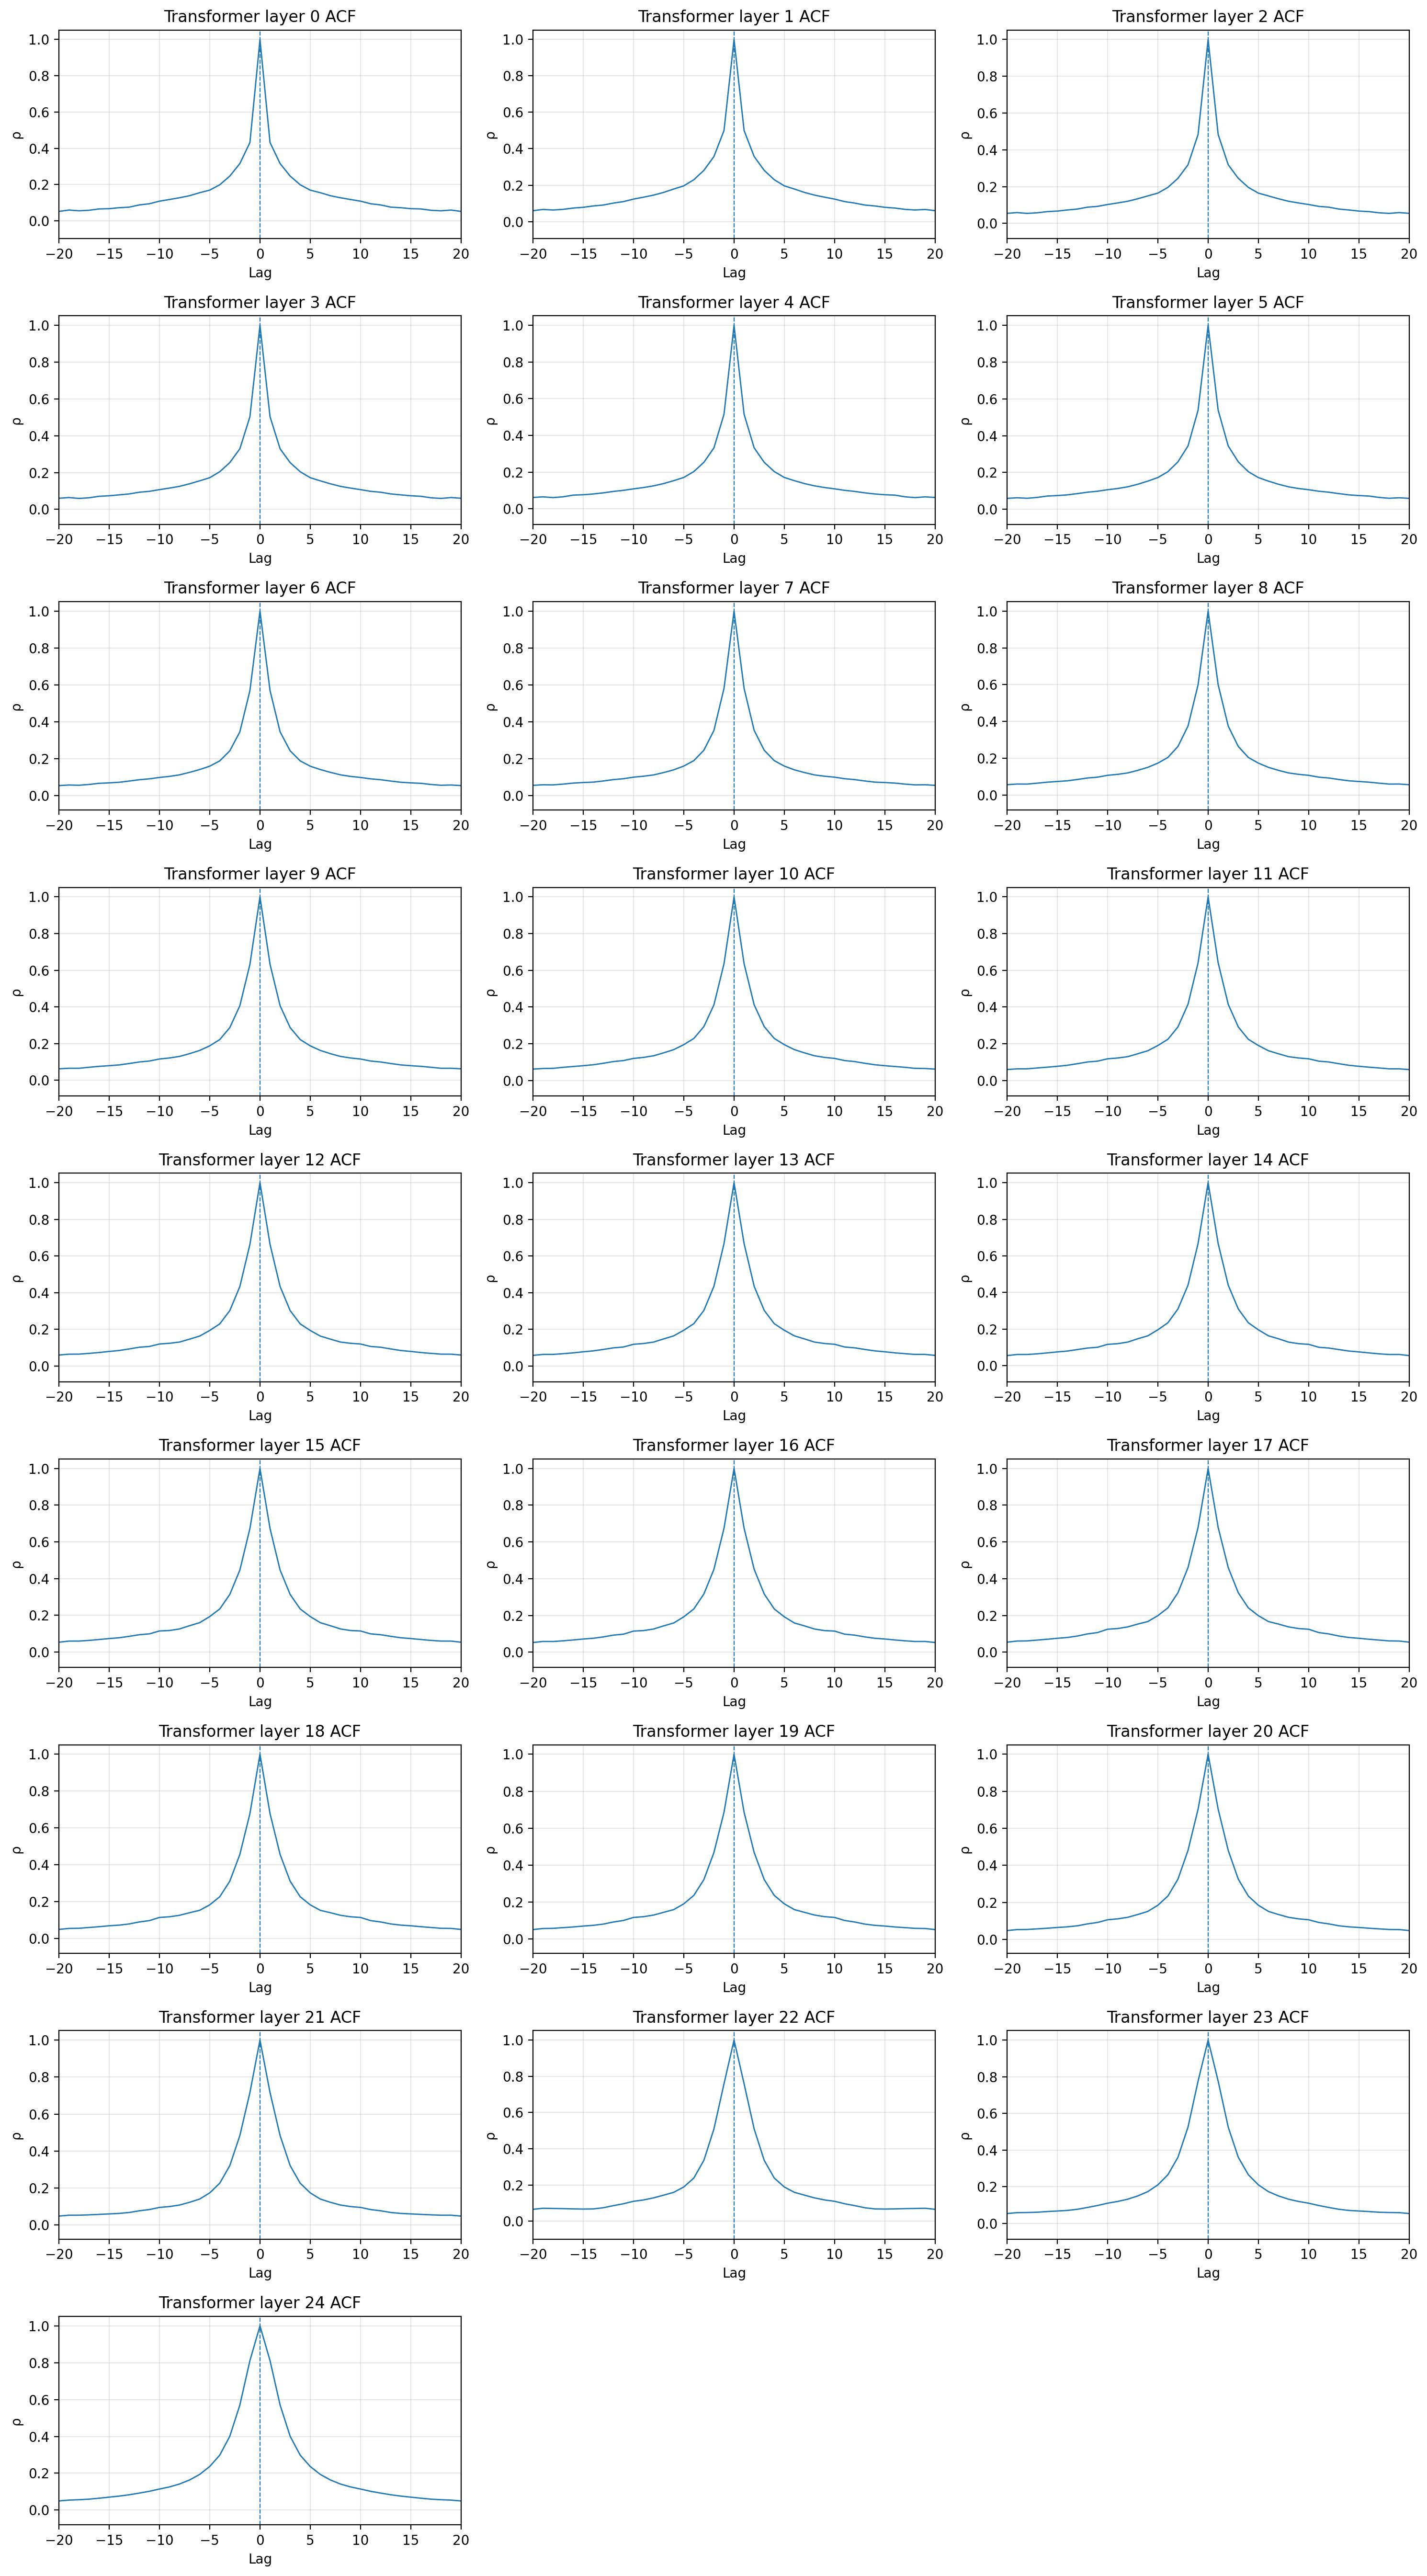

In [30]:
# plot
n_layers = len(tr_ac)
ncols = 3
nrows = math.ceil(n_layers / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 3*nrows), squeeze=False)

for i, ax in enumerate(axes.flat):
    if i >= n_layers:
        ax.axis('off')
        continue
    lags = tr_lag[i]
    ac = tr_ac[i]
    ax.plot(lags, ac, linewidth=1)
    ax.set_xlim(-20, 20)
    ax.set_title(f'Transformer layer {i} ACF')
    ax.set_xlabel('Lag')
    ax.set_ylabel('ρ')
    ax.axvline(0, linestyle='--', linewidth=0.8)
    ax.grid(True, alpha=0.3)

fig.tight_layout()


Quantify ACF with tau_int (area under ACF curve)

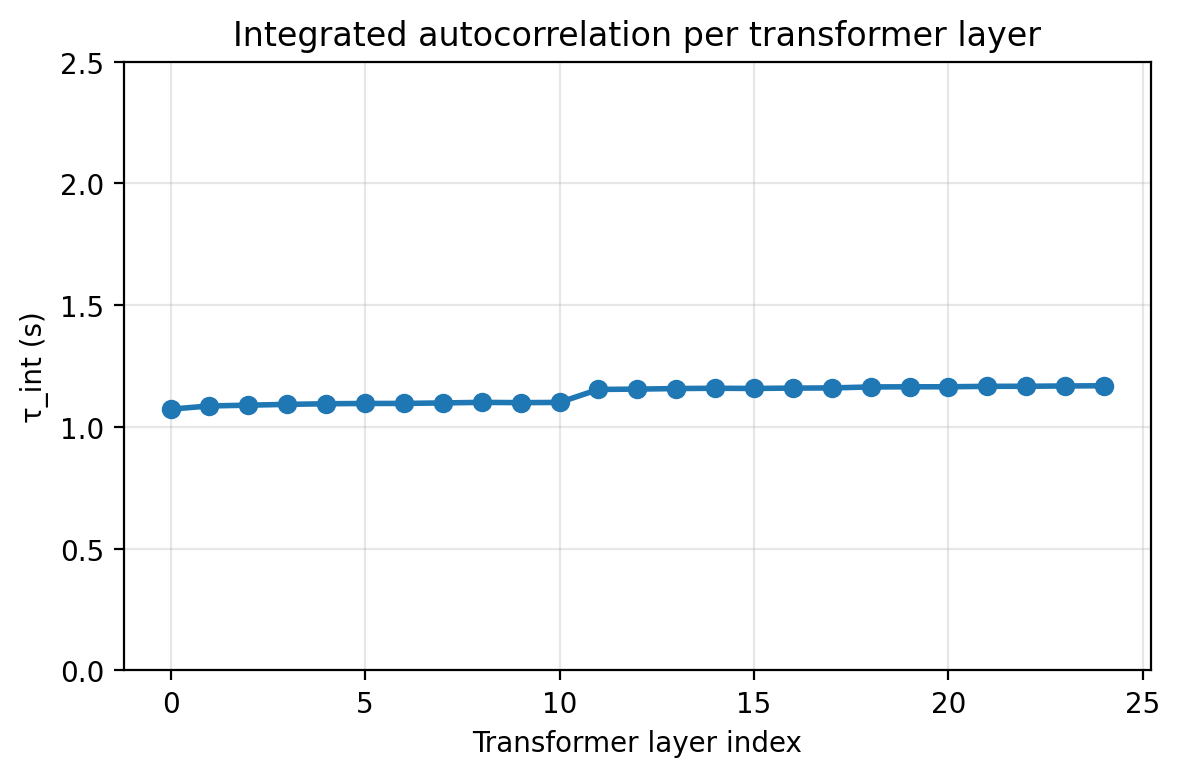

In [43]:
taus_layer = []
for tr_layer in range(len(tr_pre)):
    dt = tr_lag[tr_layer][1] - tr_lag[tr_layer][0] # duration per timestep

    mid = np.argmin(np.abs(tr_lag[tr_layer]))          # index closest to 0 s
    rho_pos = tr_ac[tr_layer][mid:]                  # [ρ(0), ρ(Δt), ρ(2Δt), ...]

    tau = integrated_autocorr_time(rho_pos, dt=dt, method="zero")
    taus_layer.append(tau)

# Plot
plt.figure(figsize=(6,4))
plt.plot(range(len(taus_layer)), taus_layer, marker='o', linewidth=2)
plt.xlabel("Transformer layer index")
plt.ylabel("τ_int (s)")
plt.ylim([0, 2.5])
plt.title("Integrated autocorrelation per transformer layer")
plt.grid(True, alpha=0.3)
plt.tight_layout()

#### Fit AR(1) to layer activations (get timescale)

In [57]:
# CNN layers
cnn_ar = []   # one value per layer

for cnn_layer in range(len(cnn_pre)):
    # Layer activations: [T_l, C]
    X = cnn_pre[cnn_layer][1].cpu().numpy()
    T_l = X.shape[0]

    # Fit AR(1) to per-unit timeseries in each layer
    per_unit_ar = []
    for u in range(X.shape[1]):
        x = X[:, u]
        x = x - x.mean()
        ar_model = sm.tsa.AutoReg(x, lags=1).fit()
        per_unit_ar.append(ar_model.params[1])

    ar_layer_avg = np.array(per_unit_ar).mean()
    cnn_ar.append(ar_layer_avg)


In [58]:
# Transformer layers
tr_ar = []   # one value per layer

for transformer_layer in range(len(tr_pre)):
    # Layer activations: [T_l, C]
    X = tr_pre[transformer_layer].cpu().numpy()
    T_l = X.shape[0]

    # Fit AR(1) to per-unit timeseries in each layer
    per_unit_ar = []
    for u in range(X.shape[1]):
        x = X[:, u]
        x = x - x.mean()
        ar_model = sm.tsa.AutoReg(x, lags=1).fit()
        per_unit_ar.append(ar_model.params[1])

    ar_layer_avg = np.array(per_unit_ar).mean()
    tr_ar.append(ar_layer_avg)
print(tr_ar)

[np.float64(0.432775092614764), np.float64(0.5003877474150596), np.float64(0.4838855345248628), np.float64(0.5040264516310167), np.float64(0.5155984559974705), np.float64(0.5387864277632757), np.float64(0.570223714367501), np.float64(0.5811639062584156), np.float64(0.6003371630414791), np.float64(0.6329802724734016), np.float64(0.6360632825162476), np.float64(0.6413466775233494), np.float64(0.6641528355858921), np.float64(0.6681391832034802), np.float64(0.6682423165561067), np.float64(0.6736767063937928), np.float64(0.6747479540924252), np.float64(0.6795592602618803), np.float64(0.6789911691377893), np.float64(0.6867867238403137), np.float64(0.7039588570895248), np.float64(0.7169486303850974), np.float64(0.7592643280671697), np.float64(0.776535290208609), np.float64(0.8120582139558381)]


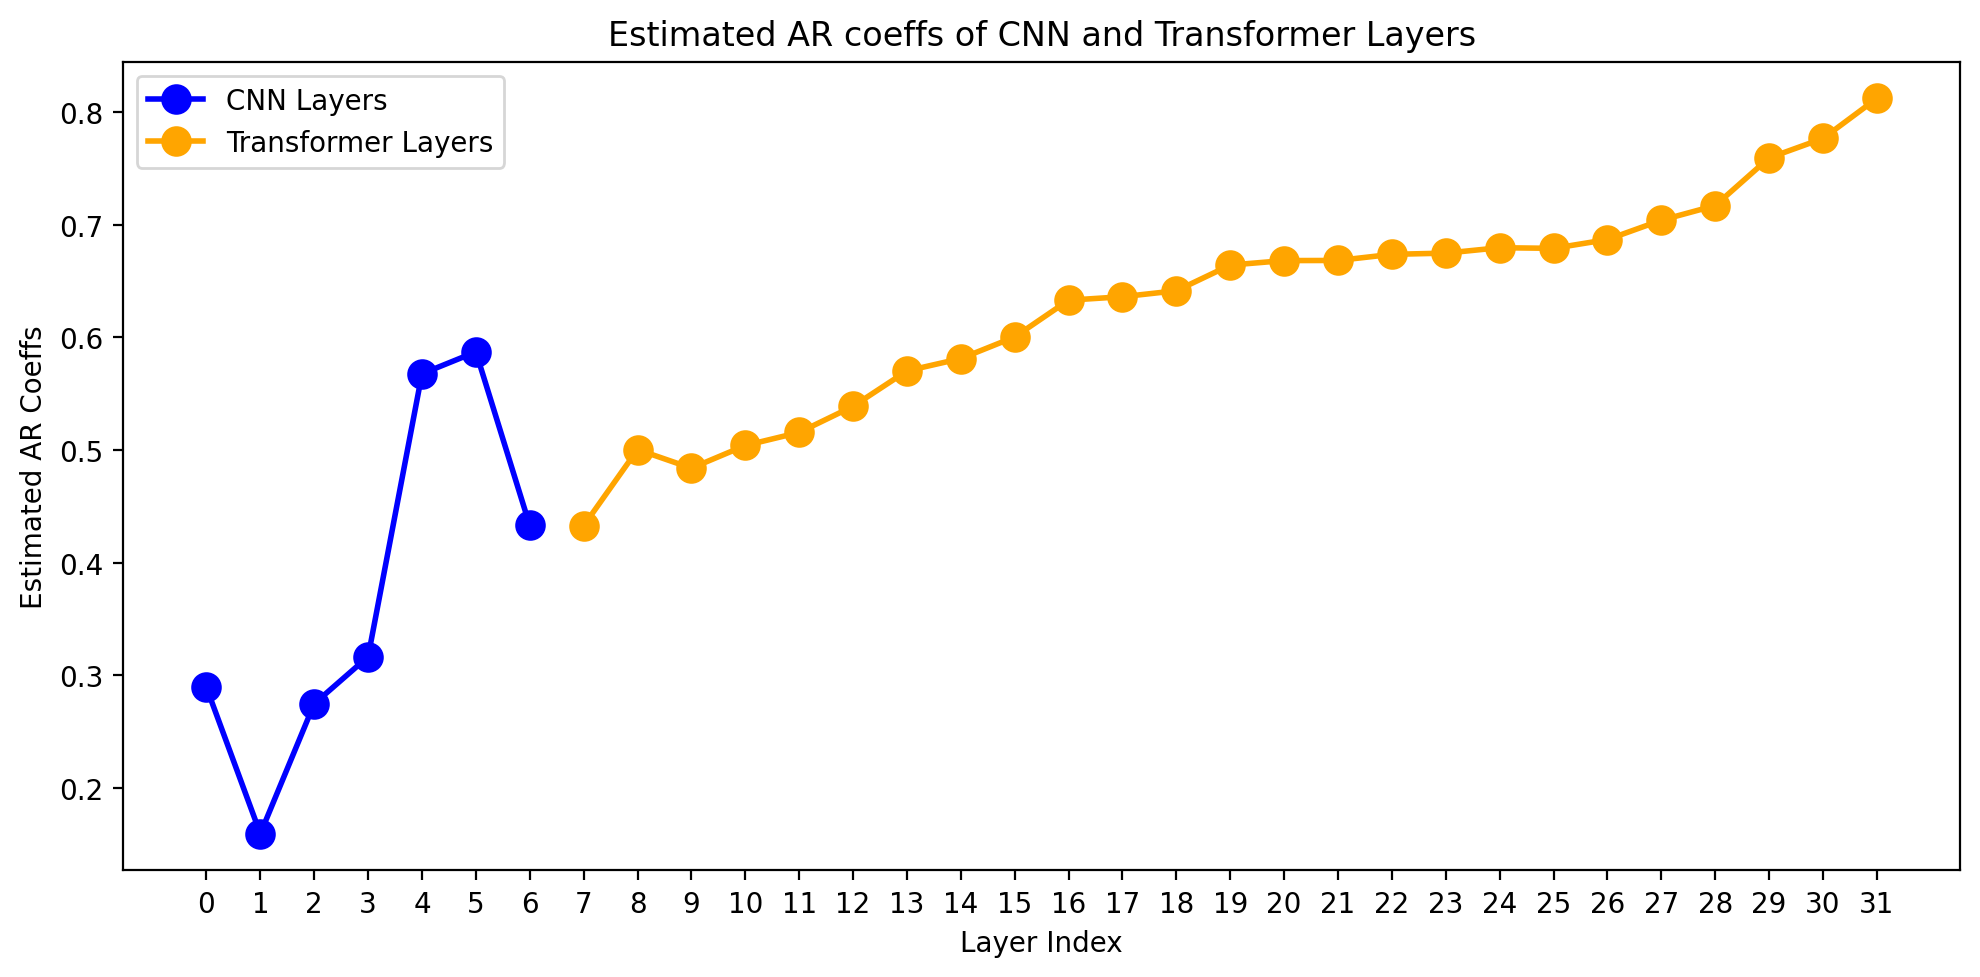

In [ ]:
# plot
layers = np.arange(len(cnn_ar) + len(tr_ar))

plt.figure(figsize=(10, 5))

plt.plot(
    layers[:len(cnn_ar)], cnn_ar,
    marker='o', markersize=10, linewidth=2,
    label='CNN Layers', color='blue'
)

plt.plot(
    layers[len(cnn_ar):], tr_ar,
    marker='o', markersize=10, linewidth=2,
    label='Transformer Layers', color='orange'
)

plt.title('Estimated AR coeffs of CNN and Transformer Layers')
plt.xlabel('Layer Index')
plt.ylabel('Estimated AR Coeffs')
plt.xticks(layers)
plt.legend()
plt.tight_layout()
save_path = os.path.join(fig_path, "wavLM_ar1.pdf")
plt.savefig(save_path, format='pdf', bbox_inches='tight')

In [ ]:
### small figure for R01

# Build the shared layer index
layers = np.arange(len(cnn_ar) + len(tr_ar))

# ---- tiny figure settings ----
dpi = 100
fig_w = 75 / dpi
fig_h = 65 / dpi

fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=dpi)

# Plot with white marker outlines sized for a small figure
ax.plot(
    layers[:len(cnn_ar)], cnn_ar,
    marker='o', markersize=2, linewidth=0.8,
    label='CNN Layers',
    color='#1f77b4',
    markerfacecolor='#1f77b4',
    markeredgecolor='white', markeredgewidth=0.3,
)

ax.plot(
    layers[len(cnn_ar):], tr_ar,
    marker='o', markersize=2, linewidth=0.8,
    label='Transformer Layers',
    color='#ff7f0e',
    markerfacecolor='#ff7f0e',
    markeredgecolor='white', markeredgewidth=0.3,
)

# Remove all text/axes
ax.set_xticks([]); ax.set_yticks([])
ax.set_xlabel(''); ax.set_ylabel(''); ax.set_title('')
for s in ax.spines.values():
    s.set_visible(False)

# Tighten drawing area
ax.margins(x=0.03, y=0.08)
fig.subplots_adjust(left=0, right=1, top=1, bottom=0)

save_path = os.path.join(fig_path, "wavLM_ar1_small.pdf")
plt.savefig(save_path, format="pdf", bbox_inches='tight', pad_inches=0)

plt.close(fig)


Archive below #################################################################################################

In [ ]:
stop
print(pre)

WavLMModel(
  (feature_extractor): WavLMFeatureEncoder(
    (conv_layers): ModuleList(
      (0): WavLMLayerNormConvLayer(
        (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (1-4): 4 x WavLMLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
      (5-6): 2 x WavLMLayerNormConvLayer(
        (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
        (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (activation): GELUActivation()
      )
    )
  )
  (feature_projection): WavLMFeatureProjection(
    (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=512, out_features=1024, bias=T

In [ ]:
import torch
import torch.nn as nn

try:
    from transformers.activations import GELUActivation
    GELU_TYPES = (nn.GELU, GELUActivation)
except Exception:
    GELU_TYPES = (nn.GELU,)


# ==== Activation/hidden-state collector ====
@torch.no_grad()
def collect_wavlm_activations(model, inputs, hook_point="layer"):
    """
    hook_point: "layer" (post-activation/norm) or "conv" (raw conv pre-act/pre-norm)
    Returns:
      cnn_outputs: list[(idx, X)] with X [T_cnn_i, C_i] (time-first)
      tr_hidden : list[Tensors] each [T_enc, D] (time-first), including hidden_states[0]
    """
    model.eval()
    cnn_outputs, handles = [], []

    def hook_fn(i):
        def _fn(mod, inp, out):
            # CNN conv blocks output [B, C, T] -> [T, C] (assuming B=1)
            x = out.detach().transpose(1, 2).squeeze(0).cpu()
            cnn_outputs.append((i, x))
        return _fn

    # Hook each conv block (or its raw conv)
    for i, layer in enumerate(model.feature_extractor.conv_layers):
        target = layer if hook_point == "layer" else layer.conv
        handles.append(target.register_forward_hook(hook_fn(i)))

    out = model(**inputs, output_hidden_states=True, return_dict=True)
    for h in handles: h.remove()

    cnn_outputs.sort(key=lambda t: t[0])
    tr_hidden = [hs.squeeze(0).cpu() for hs in out.hidden_states]  # [T_enc, D]
    return cnn_outputs, tr_hidden

# ==== Utility: replace modules only inside a subtree ====
def replace_in_subtree(root, old_types, new_factory):
    for name, child in list(root.named_children()):
        if isinstance(child, old_types):
            setattr(root, name, new_factory())
        else:
            replace_in_subtree(child, old_types, new_factory)

# ==== Utility: modify affine (γ/β) of norms inside a subtree ====
def set_norm_affine_to_unit(root):
    for m in root.modules():
        if isinstance(m, (nn.LayerNorm, nn.GroupNorm)):
            if getattr(m, "weight", None) is not None:
                with torch.no_grad():
                    m.weight.fill_(1.0)  # gamma
            if getattr(m, "bias", None) is not None:
                with torch.no_grad():
                    m.bias.zero_()       # beta

# ==== Build ablated models ====
def make_ablation(model,
                  cnn_norm="keep",        # "keep" | "remove" | "unit_affine"
                  tfm_norm="keep",        # same
                  cnn_gelu="keep",        # "keep" | "remove"
                  tfm_gelu="keep"         # same
                  ):
    """
    Returns a deep-copied model with requested ablations applied.
    - cnn_norm: affect only model.feature_extractor
    - tfm_norm: affect feature_projection + encoder (LayerNorms)
    - cnn_gelu: affect GELUs in feature_extractor
    - tfm_gelu: affect GELUs in encoder FFN (+ pos_conv activation if present)
    """
    m = copy.deepcopy(model).eval()

    # --- CNN normalization ---
    if cnn_norm == "remove":
        replace_in_subtree(m.feature_extractor, (nn.GroupNorm, nn.LayerNorm), lambda: nn.Identity())
    elif cnn_norm == "unit_affine":
        set_norm_affine_to_unit(m.feature_extractor)

    # --- Transformer-side normalization (feature_projection + encoder) ---
    if tfm_norm == "remove":
        replace_in_subtree(m.feature_projection, (nn.LayerNorm,), lambda: nn.Identity())
        replace_in_subtree(m.encoder,           (nn.LayerNorm,), lambda: nn.Identity())
    elif tfm_norm == "unit_affine":
        set_norm_affine_to_unit(m.feature_projection)
        set_norm_affine_to_unit(m.encoder)

    # --- CNN GELU ---
    if cnn_gelu == "remove":
        replace_in_subtree(m.feature_extractor, GELU_TYPES, lambda: nn.Identity())

    # --- Transformer GELU (FFN and pos_conv activation if present) ---
    if tfm_gelu == "remove":
        replace_in_subtree(m.encoder, GELU_TYPES, lambda: nn.Identity())
        # Some WavLMs also have a GELU in positional conv embed; handled by subtree replace.

    return m

# ==== Runner for one condition ====
def run_condition(model, inputs, duration_sec, name, hook_point="layer"):
    cnn, tr = collect_wavlm_activations(model, inputs, hook_point=hook_point)

    # CNN per-layer curvature
    cnn_deg_step, cnn_deg_sec, cnn_deg_dist = [], [], []
    for _, X in cnn:                           # X: [T_i, C_i]
        dps, dps_sec, dps_dist = avg_curvature(X.numpy(), duration_sec)
        cnn_deg_step.append(dps)
        cnn_deg_sec.append(dps_sec)
        cnn_deg_dist.append(dps_dist)

    # Transformer per-layer curvature (including hidden_states[0])
    tr_deg_step, tr_deg_sec, tr_deg_dist = [], [], []
    for H in tr:                               # H: [T_enc, D]
        dps, dps_sec, dps_dist = avg_curvature(H.numpy(), duration_sec)
        tr_deg_step.append(dps)
        tr_deg_sec.append(dps_sec)
        tr_deg_dist.append(dps_dist)

    return {
        "name": name,
        "cnn_per_step": np.array(cnn_deg_step),
        "cnn_per_sec":  np.array(cnn_deg_sec),
        "cnn_per_dist": np.array(cnn_deg_dist),
        "tr_per_step":  np.array(tr_deg_step),
        "tr_per_sec":   np.array(tr_deg_sec),
        "tr_per_dist":  np.array(tr_deg_dist)
    }

# ==== Example usage ====
# Assume you already have:
#   - waveform: torch.FloatTensor [1, num_samples] at 16 kHz
#   - feature_extractor, pre (pretrained WavLM), inputs prepared on device

sr = 16000
duration_sec = float(waveform.shape[-1]) / sr

device = next(pre.parameters()).device
inputs = feature_extractor(waveform, sampling_rate=sr, return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}

# Baseline
baseline = run_condition(pre, inputs, duration_sec, name="baseline", hook_point="layer")

# Remove ONLY CNN normalization
cnn_no_norm = run_condition(
    make_ablation(pre, cnn_norm="remove", tfm_norm="keep", cnn_gelu="keep", tfm_gelu="keep"),
    inputs, duration_sec, name="cnn_no_norm", hook_point="layer"
)

# Remove ONLY Transformer normalization (incl. feature_projection LN)
tfm_no_norm = run_condition(
    make_ablation(pre, cnn_norm="keep", tfm_norm="remove", cnn_gelu="keep", tfm_gelu="keep"),
    inputs, duration_sec, name="tfm_no_norm", hook_point="layer"
)

# Keep standardization but remove learned affine (γ/β) everywhere
unit_affine_all = run_condition(
    make_ablation(pre, cnn_norm="unit_affine", tfm_norm="unit_affine", cnn_gelu="keep", tfm_gelu="keep"),
    inputs, duration_sec, name="unit_affine_all", hook_point="layer"
)

# Remove ONLY CNN GELU
cnn_no_gelu = run_condition(
    make_ablation(pre, cnn_norm="keep", tfm_norm="keep", cnn_gelu="remove", tfm_gelu="keep"),
    inputs, duration_sec, name="cnn_no_gelu", hook_point="layer"
)

# Remove ONLY Transformer GELU (FFN and pos_conv activation)
tfm_no_gelu = run_condition(
    make_ablation(pre, cnn_norm="keep", tfm_norm="keep", cnn_gelu="keep", tfm_gelu="remove"),
    inputs, duration_sec, name="tfm_no_gelu", hook_point="layer"
)

# (Optional) Collect all for quick comparison
conditions = [baseline, cnn_no_norm, tfm_no_norm, unit_affine_all, cnn_no_gelu, tfm_no_gelu]

# Tiny text report: slope (straightening) across layers for Transformer
def slope(y):
    x = np.arange(len(y))
    if len(x) < 2: return 0.0
    A = np.vstack([x, np.ones_like(x)]).T
    m, b = np.linalg.lstsq(A, y, rcond=None)[0]
    return float(m)

print("\n=== Straightening summary (Transformer) ===")
for c in conditions:
    m_step = slope(c["tr_per_step"])
    m_sec  = slope(c["tr_per_sec"])
    print(f"{c['name']:>16}: slope(deg/step)={m_step:+.3f}, slope(deg/sec)={m_sec:+.3f}")

print("\n=== Straightening summary (CNN) ===")
for c in conditions:
    m_step = slope(c["cnn_per_step"])
    m_sec  = slope(c["cnn_per_sec"])
    print(f"{c['name']:>16}: slope(deg/step)={m_step:+.3f}, slope(deg/sec)={m_sec:+.3f}")


NameError: name 'copy' is not defined

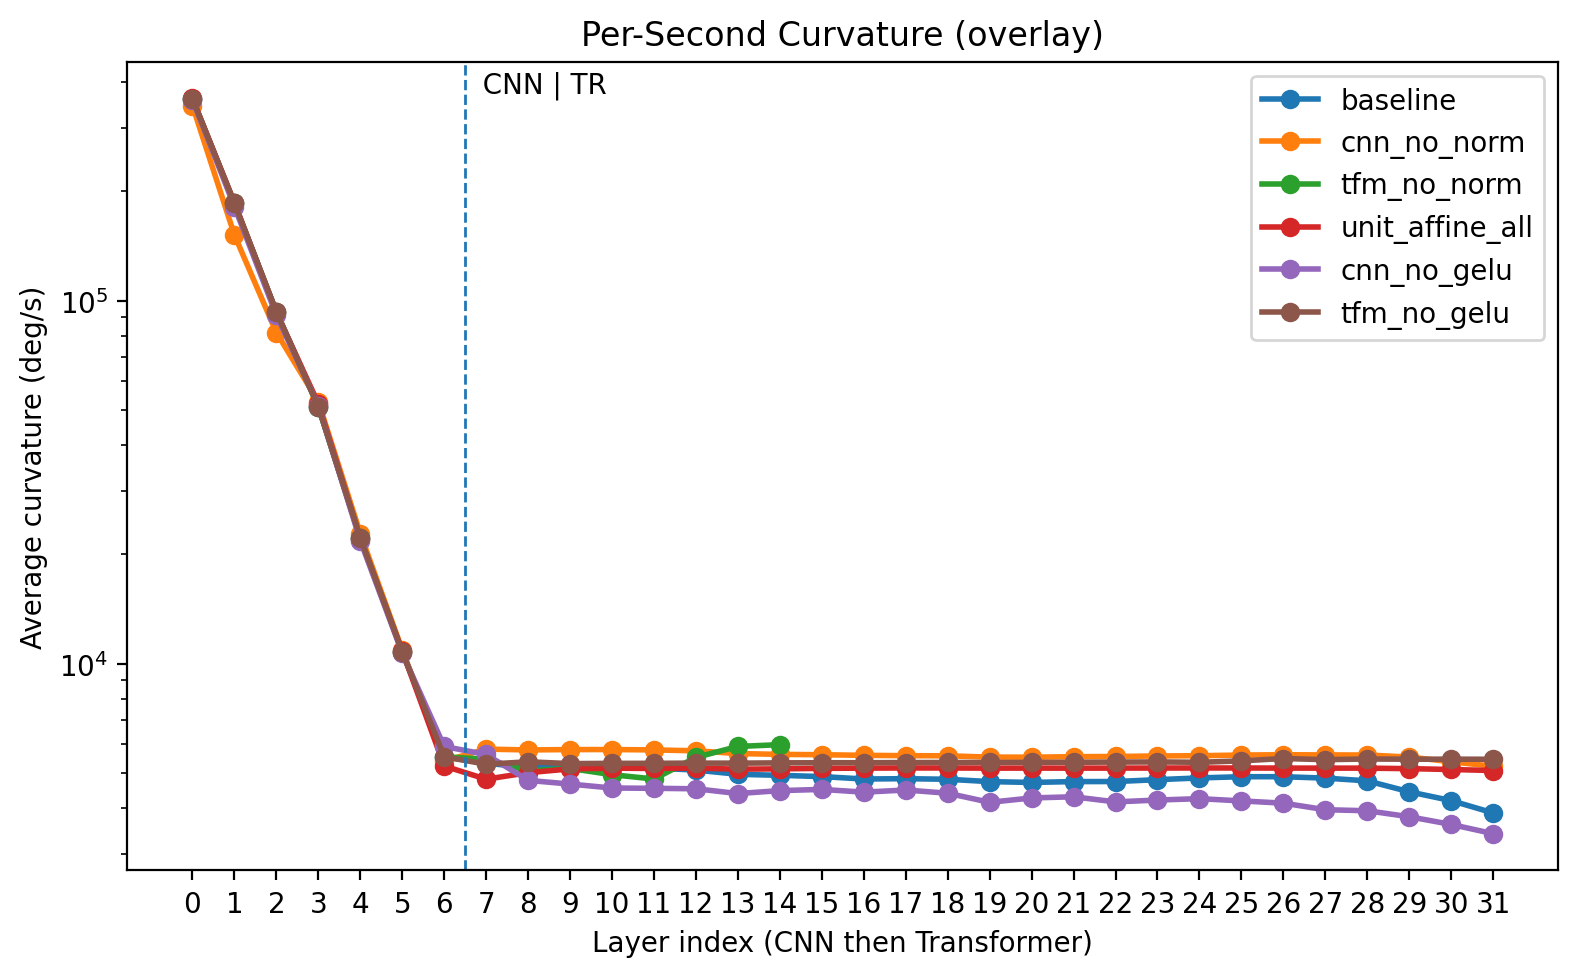

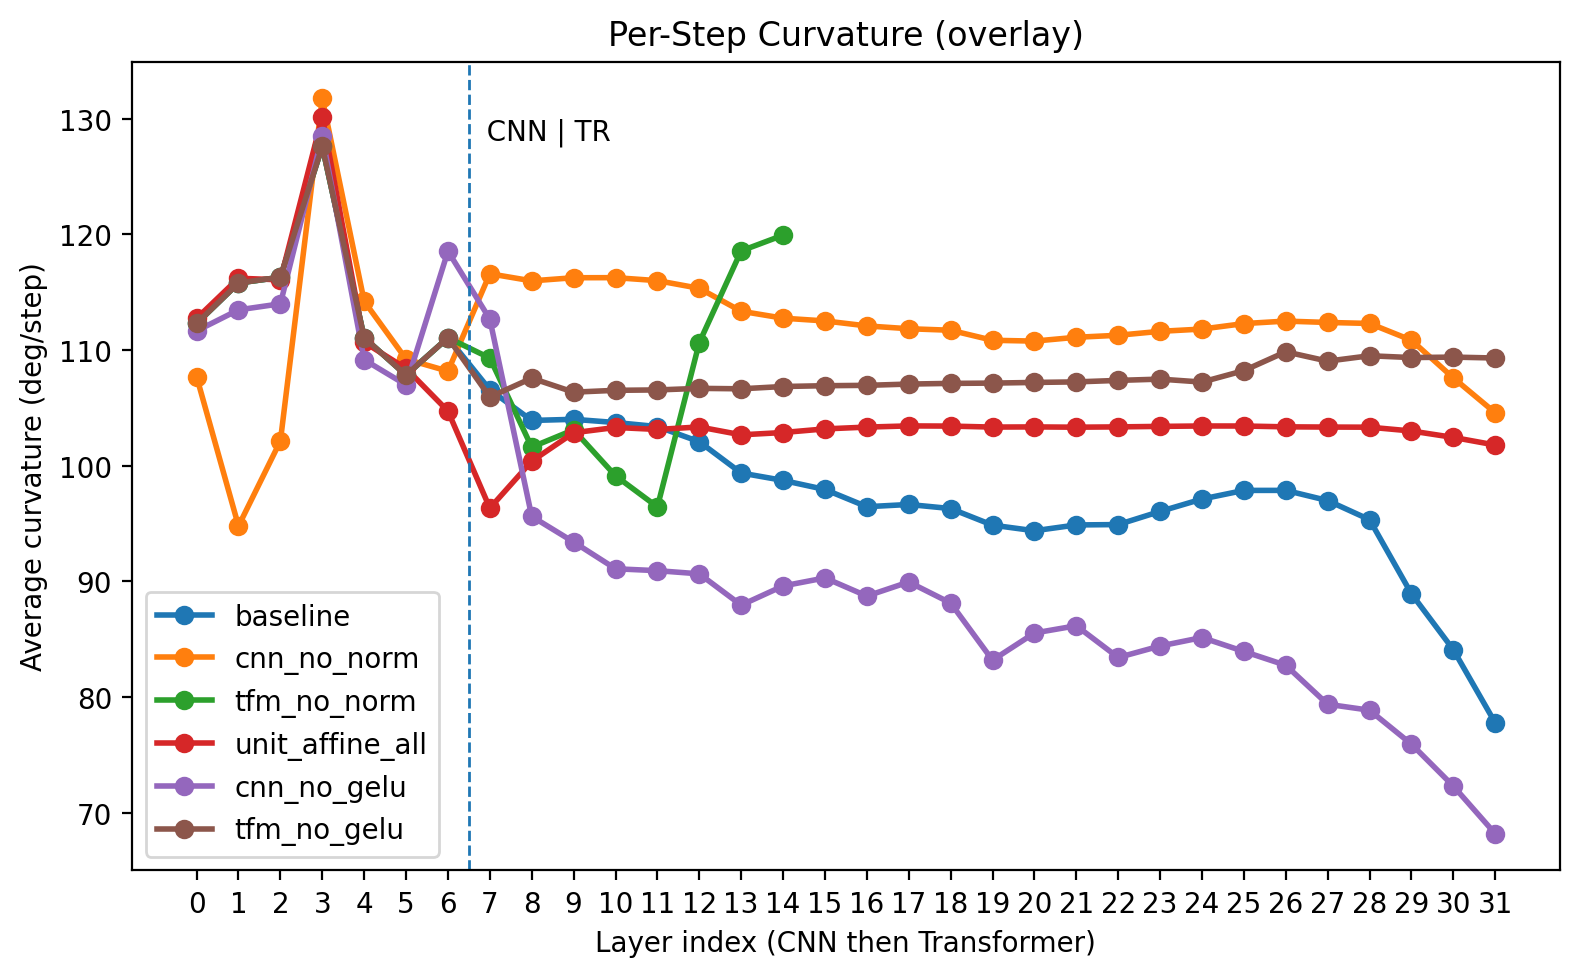

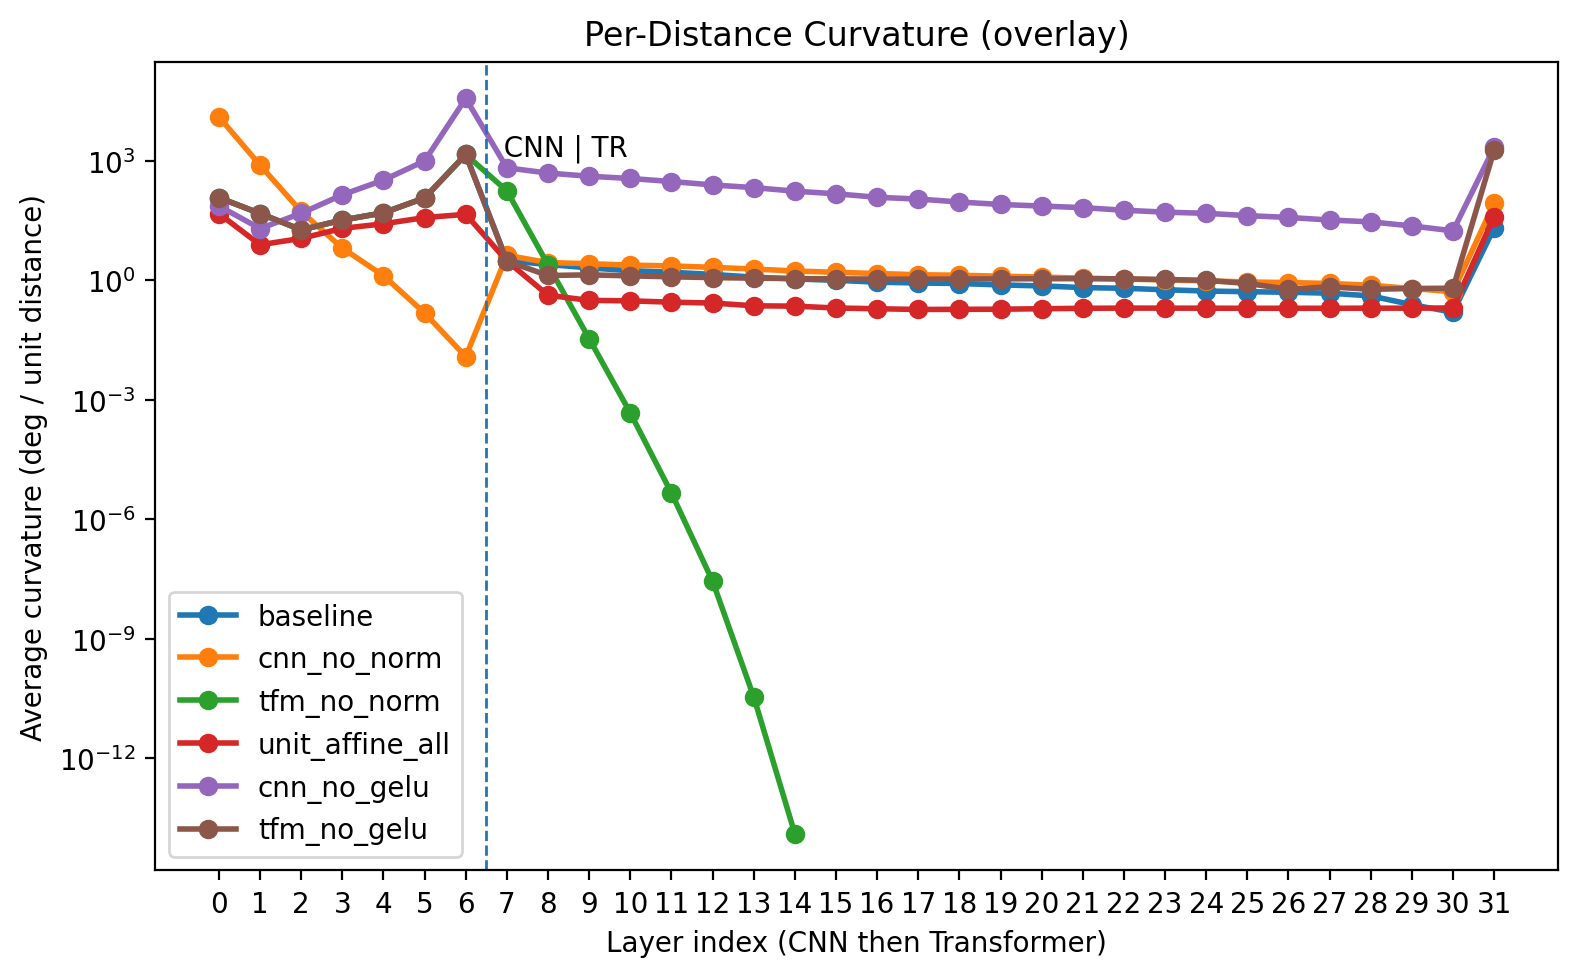

In [ ]:
# Plotting helpers for curvature results from the ablation harness.
# This expects `conditions` from the earlier code (each item has keys:
# "name", "cnn_per_sec", "tr_per_sec", "cnn_per_step", "tr_per_step").
# If `conditions` is not defined yet, this cell will not error; it will show how to use the plotting functions.


def _concat_cnn_tr(c):
    """Return concatenated arrays and boundary index."""
    cnn = np.asarray(c["cnn_per_sec"])
    tr  = np.asarray(c["tr_per_sec"])
    boundary = len(cnn)  # index where Transformer starts
    combo = np.concatenate([cnn, tr])
    return combo, boundary

def _concat_cnn_tr_step(c):
    cnn = np.asarray(c["cnn_per_step"])
    tr  = np.asarray(c["tr_per_step"])
    boundary = len(cnn)
    combo = np.concatenate([cnn, tr])
    return combo, boundary


def _concat_cnn_tr_dist(c):
    """Concatenate CNN and Transformer per-distance curvature; return array and boundary index."""
    cnn = np.asarray(c["cnn_per_dist"])
    tr  = np.asarray(c["tr_per_dist"])
    boundary = len(cnn)  # index where Transformer starts
    combo = np.concatenate([cnn, tr])
    return combo, boundary

def plot_per_second_curvature(conditions, select_names=None, title="Per-Second Curvature (CNN→Transformer)", use_log=True):
    """
    Overlays per-second curvature lines (CNN+Transformer concatenated) for the selected conditions.
    Each condition is one line; the CNN/TR boundary is marked.
    """
    if select_names is None:
        # plot all by default
        sel = conditions
    else:
        wanted = set(select_names)
        sel = [c for c in conditions if c["name"] in wanted]
    if not sel:
        print("No matching conditions to plot.")
        return

    # Use the first condition to size the x-axis and boundary
    combo0, boundary0 = _concat_cnn_tr(sel[0])
    x = np.arange(len(combo0))

    plt.figure(figsize=(8, 5))
    # Plot each condition as one line
    for c in sel:
        combo, boundary = _concat_cnn_tr(c)
        if len(combo) != len(combo0) or boundary != boundary0:
            print(f"Warning: {c['name']} has a different length or boundary; skipping.")
            continue
        plt.plot(x, combo, marker='o', markersize=6, linewidth=2, label=c["name"])

    # Mark CNN / Transformer split
    plt.axvline(boundary0 - 0.5, linestyle='--', linewidth=1)
    plt.text(boundary0 - 0.5, np.nanmax(combo0), "  CNN | TR", va='bottom', ha='left')

    if use_log:
        plt.yscale("log")
    plt.title(title)
    plt.xlabel("Layer index (CNN then Transformer)")
    plt.ylabel("Average curvature (deg/s)")
    plt.xticks(x)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_per_step_curvature(conditions, select_names=None, title="Per-Step Curvature (CNN→Transformer)"):
    """
    Overlays per-step curvature lines (CNN+Transformer concatenated) for the selected conditions.
    Each condition is one line; the CNN/TR boundary is marked.
    """
    if select_names is None:
        sel = conditions
    else:
        wanted = set(select_names)
        sel = [c for c in conditions if c["name"] in wanted]
    if not sel:
        print("No matching conditions to plot.")
        return

    combo0, boundary0 = _concat_cnn_tr_step(sel[0])
    x = np.arange(len(combo0))

    plt.figure(figsize=(8, 5))
    for c in sel:
        combo, boundary = _concat_cnn_tr_step(c)
        if len(combo) != len(combo0) or boundary != boundary0:
            print(f"Warning: {c['name']} has a different length or boundary; skipping.")
            continue
        plt.plot(x, combo, marker='o', markersize=6, linewidth=2, label=c["name"])

    plt.axvline(boundary0 - 0.5, linestyle='--', linewidth=1)
    plt.text(boundary0 - 0.5, np.nanmax(combo0), "  CNN | TR", va='bottom', ha='left')

    plt.title(title)
    plt.xlabel("Layer index (CNN then Transformer)")
    plt.ylabel("Average curvature (deg/step)")
    plt.xticks(x)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_per_distance_curvature(
    conditions,
    select_names=None,
    title="Per-Distance Curvature (CNN→Transformer)",
    use_log=True,
    distance_unit="unit distance"
):
    if select_names is None:
        sel = conditions
    else:
        wanted = set(select_names)
        sel = [c for c in conditions if c["name"] in wanted]

    if not sel:
        print("No matching conditions to plot.")
        return

    # Reference x-axis length & boundary from the first selected condition
    combo0, boundary0 = _concat_cnn_tr_dist(sel[0])
    x = np.arange(len(combo0))

    plt.figure(figsize=(8, 5))
    for c in sel:
        combo, boundary = _concat_cnn_tr_dist(c)
        if len(combo) != len(combo0) or boundary != boundary0:
            print(f"Warning: {c['name']} has a different length or boundary; skipping.")
            continue
        plt.plot(x, combo, marker='o', markersize=6, linewidth=2, label=c["name"])

    # Mark CNN / Transformer split
    plt.axvline(boundary0 - 0.5, linestyle='--', linewidth=1)
    # Place the label a bit below the current top to avoid clipping on log scale
    ymax = np.nanmax(combo0)
    ytext = ymax / (1.5 if use_log else 1.0)
    plt.text(boundary0 - 0.5, ytext, "  CNN | TR", va='bottom', ha='left')

    if use_log:
        plt.yscale("log")

    plt.title(title)
    plt.xlabel("Layer index (CNN then Transformer)")
    plt.ylabel(f"Average curvature (deg / {distance_unit})")
    plt.xticks(x)
    plt.legend()
    plt.tight_layout()
    plt.show()

if "conditions" in globals() and isinstance(conditions, (list, tuple)) and conditions:
    # Example: show baseline + two ablations if they exist
    names = [c["name"] for c in conditions]
    preferred = []
    for cand in ["baseline", "cnn_no_norm", "tfm_no_norm", "unit_affine_all", "cnn_no_gelu", "tfm_no_gelu"]:
        if cand in names:
            preferred.append(cand)
    select = preferred if preferred else names  # fall back to all

    plot_per_second_curvature(conditions, select_names=select, title="Per-Second Curvature (overlay)")
    plot_per_step_curvature(conditions,   select_names=select, title="Per-Step Curvature (overlay)")
    plot_per_distance_curvature(conditions, select_names=select, title="Per-Distance Curvature (overlay)")
else:
    print(
        "Plotting functions are defined. After you run the ablation harness and get `conditions`, call:\n"
        "  plot_per_second_curvature(conditions,  select_names=['baseline','tfm_no_norm'])\n"
        "  plot_per_step_curvature(conditions,    select_names=['baseline','tfm_no_norm'])\n"
        "  plot_per_distance_curvature(conditions, select_names=['baseline','tfm_no_norm'])"
    )

